# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Applied AI in Biomed/

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1m33L_-cg9GGaF5w8ZpdMxLGX7wutvAV5/Applied AI in Biomed


## Libraries

In [ ]:
import os
import random
import warnings
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xml.dom import minidom
from concurrent.futures import ThreadPoolExecutor
import scipy
from PIL import Image
from skimage import morphology
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm

import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV3Large
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mob_pre
from tensorflow.keras.models import Model

## Environment Setup

In [ ]:
# Set seed for reproducibility
seed = 42

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Set seeds for random number generators
np.random.seed(seed)
random.seed(seed)

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

## Load Data


In [ ]:
# Imports and load the two datasets
data_full = np.load('imbalanced_datasets/fullslice_dataset.npz')
X_full, y_full = data_full['X'], data_full['y']

data_nodule = np.load('imbalanced_datasets/nodule_dataset.npz')
X_nod, y_nod = data_nodule['X'], data_nodule['y']

In [ ]:
# Inspect shapes and value ranges
print('Fullslice images shape:', X_full.shape)
print('Fullslice labels shape:', y_full.shape, ' unique labels:', np.unique(y_full))
print('  pixel range:', X_full.min(), 'to', X_full.max())

print('Nodule images shape:', X_nod.shape)
print('Nodule labels shape:', y_nod.shape, ' unique labels:', np.unique(y_nod))
print('  pixel range:', X_nod.min(), 'to', X_nod.max())

Fullslice images shape: (2363, 224, 224)
Fullslice labels shape: (2363,)  unique labels: [1 2 3 4 5]
  pixel range: -2.5038006 to 3.156933
Nodule images shape: (2363, 224, 224)
Nodule labels shape: (2363,)  unique labels: [1 2 3 4 5]
  pixel range: -4.986176 to 19.447622


# Outlier Detection

t-SNE employed for lower-dimensionality data projection. Pixels space embeds no semantic information, only pixel value, therefore only completely dark or white images may be detected as outliers.

Employing pretrained feature extractors to embed images in a lower-dimensional space that encodes for semantics might help in discriminating possible outliers in the two-dimensional porjected plane.

## Features Extraction

This t-SNE projection visualizes high-dimensional image data (nodule CT slices) in 2D space. Each point represents one sample, colored by its label:

- The clustering patterns suggest your data has structure — samples with the same class often group together.

- Some overlap is expected since t-SNE is non-linear and aims to preserve local relationships, not global distances.

In [ ]:
def preprocess_images(images, size, preprocess_fn):
    if images.ndim == 3:
        images = images[..., np.newaxis]
    if images.shape[-1] == 1:
        resized = tf.image.grayscale_to_rgb(tf.image.resize(images, size))
    elif images.shape[-1] == 3:
        resized = tf.image.resize(images, size)
    else:
        raise ValueError("Unsupported channel format")
    return preprocess_fn(resized.numpy())

def extract_features(model, images):
    features = model.predict(images, verbose=0)
    return features.reshape(features.shape[0], -1)

def process_and_plot(X, y, model_name, dataset_name):
    print(f"\n\u2728 Processing {model_name} on {dataset_name} dataset...")
    config = models_config[model_name]
    model = Model(inputs=config['model'].input, outputs=config['model'].output)
    imgs = preprocess_images(X, config['size'], config['preprocess'])
    feats = extract_features(model, imgs)
    scaled = StandardScaler().fit_transform(feats)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(scaled)

    label_names = {
        1: 'Healthy',
        2: 'Doubtful',
        3: 'Minimal',
        4: 'Moderate',
        5: 'Severe'
    }
    unique_labels = np.unique(y)

    cmap = cm.get_cmap('viridis', len(unique_labels))
    norm = BoundaryNorm(boundaries=np.arange(0.5, len(unique_labels)+1), ncolors=len(unique_labels))

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y, cmap=cmap, norm=norm, edgecolor='k', s=50)
    cbar = plt.colorbar(scatter, ticks=unique_labels)
    cbar.set_label('Labels', rotation=270, labelpad=15)
    cbar.set_ticks(unique_labels)
    cbar.set_ticklabels([label_names[l] for l in unique_labels])
    plt.title(f't-SNE Projection - {model_name} on {dataset_name}')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    save_dir = "/gdrive/MyDrive/Applied AI in Biomed/Plots"
    os.makedirs(save_dir, exist_ok=True)
    filename = f"{model_name}_{dataset_name}_tsne.png"
    plt.savefig(os.path.join(save_dir, filename))
    plt.show()

    # Free memory
    tf.keras.backend.clear_session()
    del model

##  Overview of Feature Extraction Models

Selected MobileNetV3-Large, ResNet-50, and VGG-16 for outlier detection:

*   MobileNetV3-Large: Designed for efficiency, it captures fine-grained, low-level features with minimal computational overhead, making it suitable for large-scale preliminary analyses.
*   ResNet-50: Its residual connections facilitate the learning of complex, high-level abstractions, effectively capturing nuanced patterns in medical images.
*   VGG-16: With its uniform architecture and small convolutional filters, VGG-16 excels at extracting mid-level features, providing a balance between detail and abstraction.

We wanted to choose three architecture with complementary features in order to represent the same data under different points of view, from low-level details to high-level abstractions, enhancing the robustness of outlier detection.

In [ ]:
models_config = {
    'VGG16': {'model': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
              'preprocess': vgg_pre, 'size': (224, 224)},
    'ResNet50': {'model': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
                 'preprocess': res_pre, 'size': (224, 224)},
    'MobileNetV3Large': {'model': MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
                         'preprocess': mob_pre, 'size': (224, 224)}
}

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step



✨ Processing VGG16 on Fullslice dataset...


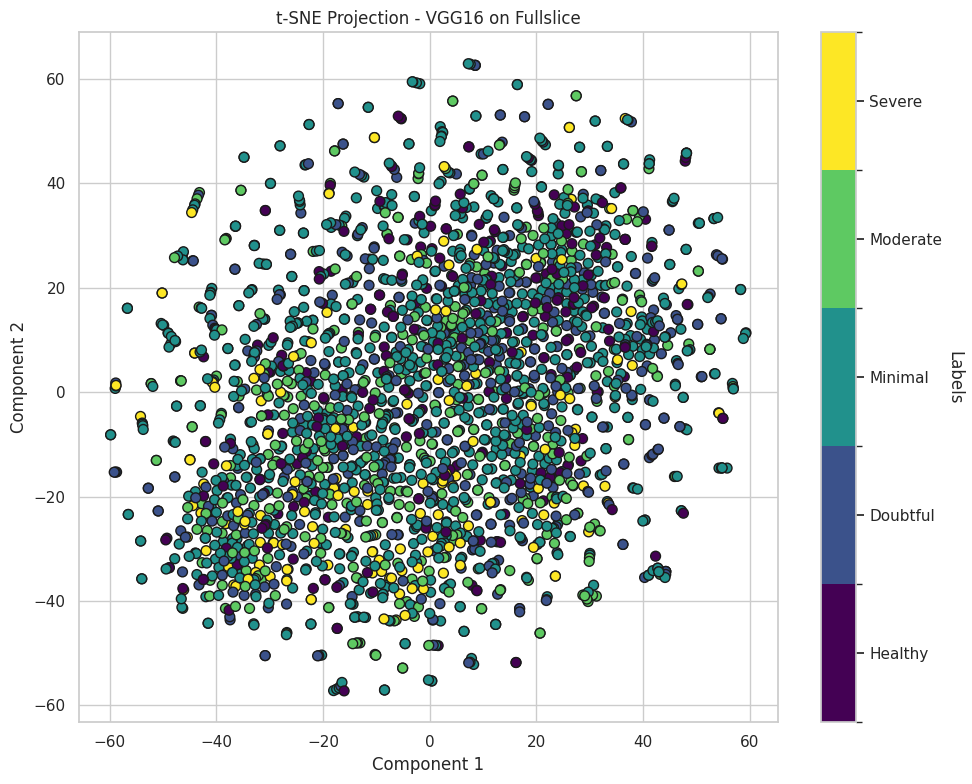


✨ Processing VGG16 on Nodule dataset...


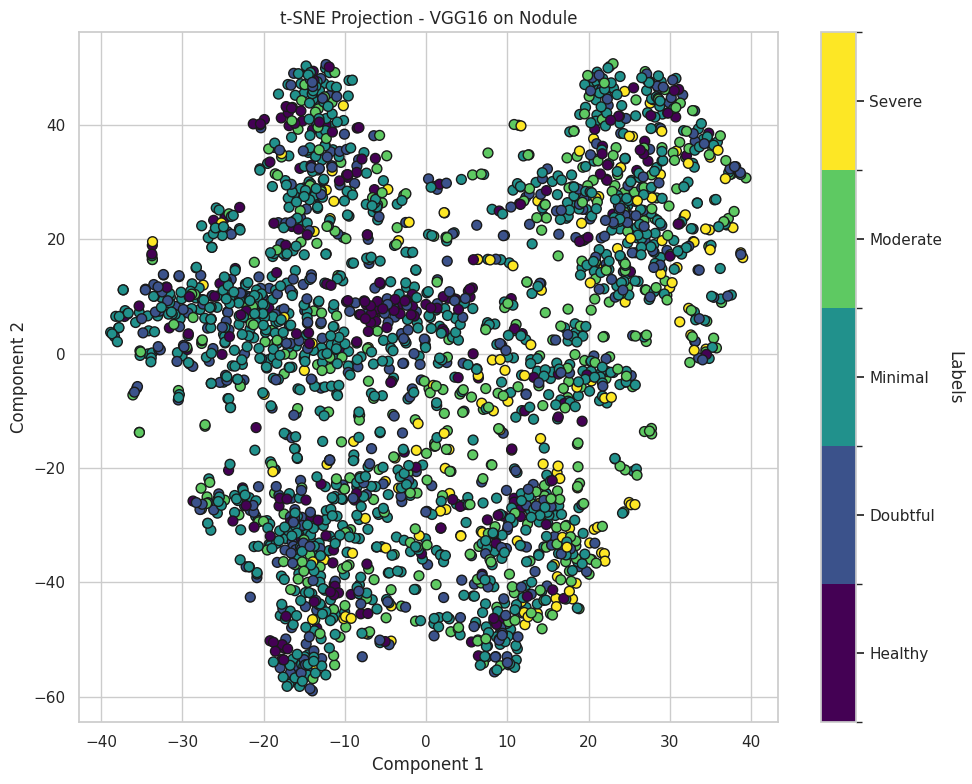

In [ ]:
process_and_plot(X_full, y_full, 'VGG16', "Fullslice")
process_and_plot(X_nod, y_nod, 'VGG16', "Nodule")


✨ Processing ResNet50 on Fullslice dataset...


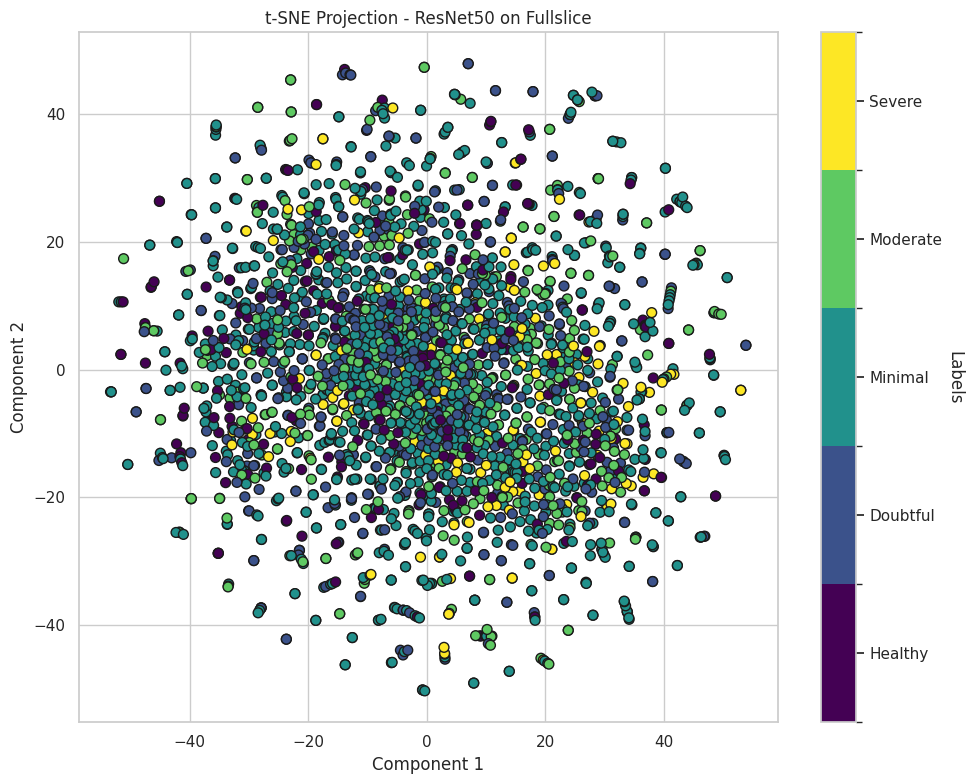


✨ Processing ResNet50 on Nodule dataset...


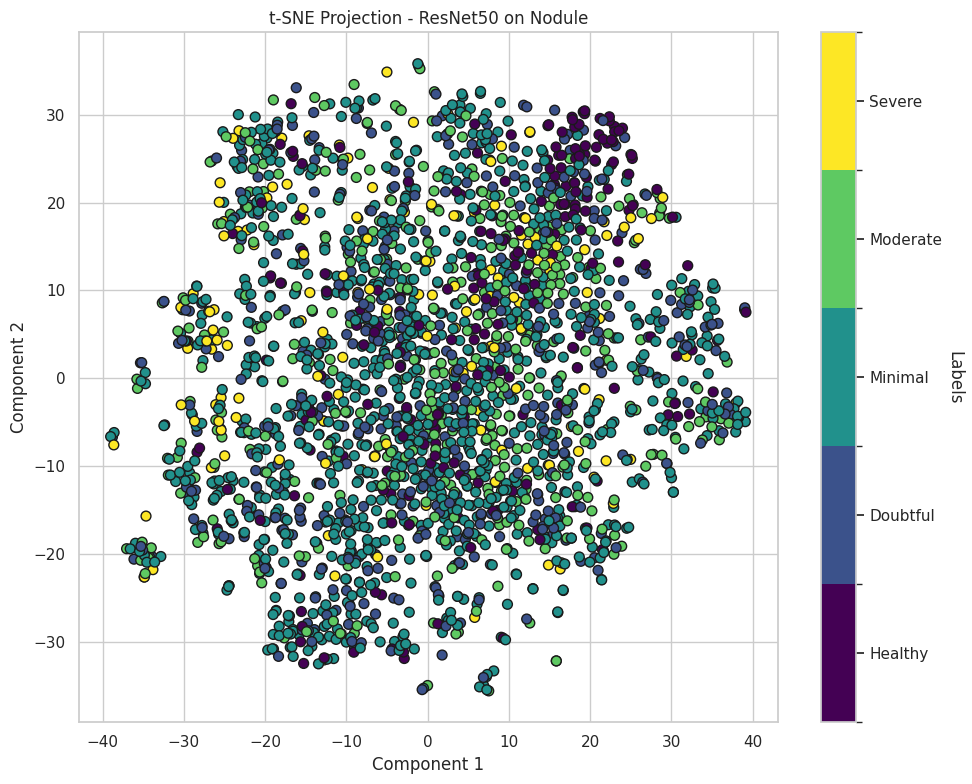

In [ ]:
process_and_plot(X_full, y_full, 'ResNet50', "Fullslice")
process_and_plot(X_nod, y_nod, 'ResNet50', "Nodule")


✨ Processing MobileNetV3Large on Fullslice dataset...


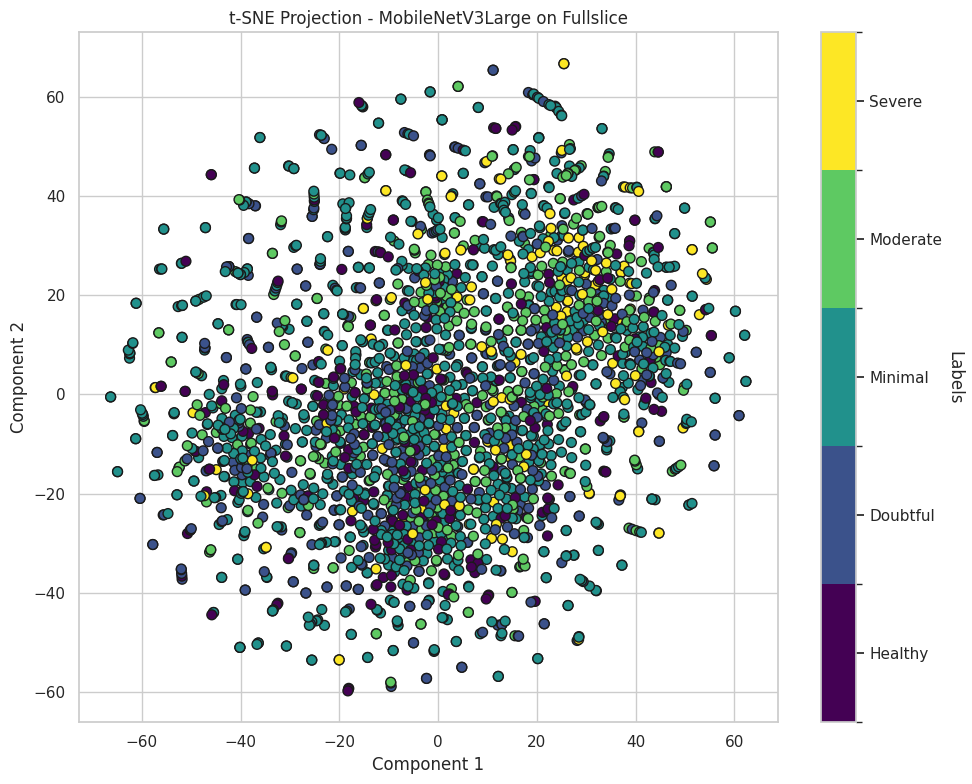


✨ Processing MobileNetV3Large on Nodule dataset...


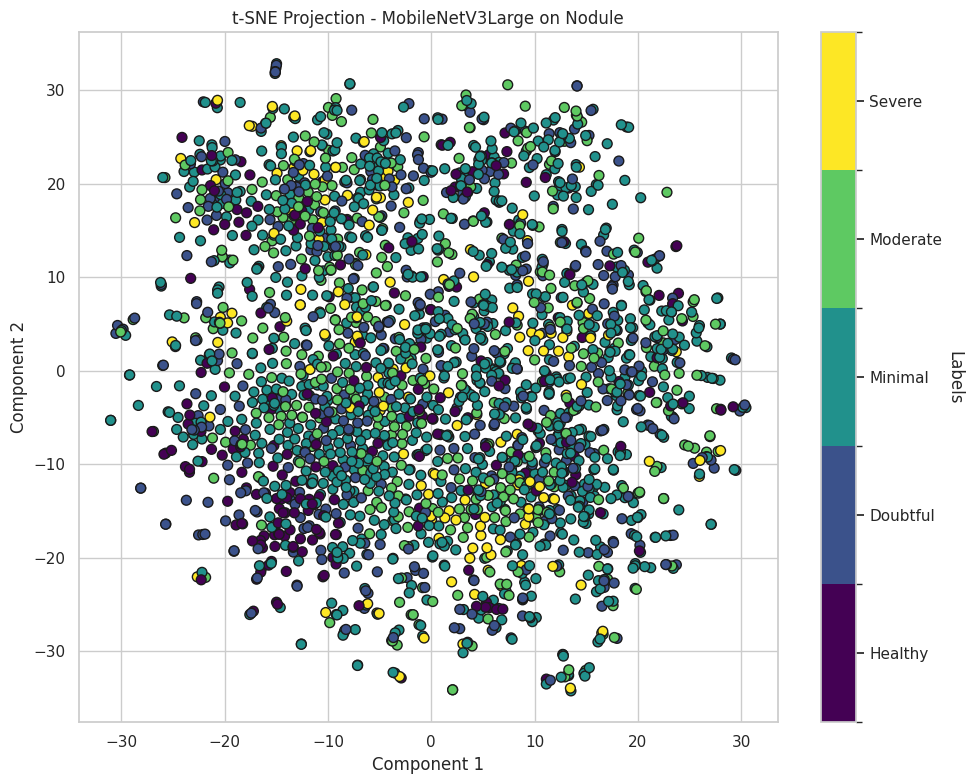

In [ ]:
process_and_plot(X_full, y_full, 'MobileNetV3Large', "Fullslice")
process_and_plot(X_nod, y_nod, 'MobileNetV3Large', "Nodule")


## Comparison of Feature Extractors via t-SNE

| Model             | Fullslice                           | Nodule                             | Notes                                                                 |
|------------------|--------------------------------------|------------------------------------|-----------------------------------------------------------------------|
| **VGG16**         | Blurry clusters, overlap             | Clear separation, dense structure  | Strong with localized features, best performance on nodules          |
| **ResNet50**      | Mild improvement, still diffuse      | Better grouping, fewer outliers    | Deeper network improves structure, reliable on both views            |
| **MobileNetV3**   | Fast but noisy                      | Moderately grouped, some scatter   | Lightweight, efficient, but less consistent cluster formation         |

Summary:
Best for localized features: VGG16 on nodules

Best trade-off of performance + generality: ResNet50

Lightweight but slightly noisier: MobileNetV3

## Justifying the Neglect of Outliers in CT Image Datasets

1. **Robustness of Deep Learning Models to Outliers:**

- Deep learning architectures, such as CNNs, have demonstrated resilience to minor noise and outliers in image data. This robustness is attributed to their ability to learn hierarchical feature representations, which can mitigate the impact of anomalous data points .

2. **Potential Misclassification of Rare but Relevant Cases:**

- Outliers in medical imaging datasets may represent rare but clinically significant cases. Removing these could inadvertently exclude critical variations necessary for comprehensive model training .

3. **Projection Artifacts in Dimensionality Reduction Techniques:**

- Techniques like t-SNE are effective for visualization but can sometimes produce misleading representations of high-dimensional data. Apparent outliers in t-SNE plots may not correspond to true anomalies in the original feature space .



# Addressing Class Imbalance

In [ ]:
# print and plot the 5-class distribution with counts and percentages
classes, counts = np.unique(y_full, return_counts=True)
total = y_full.shape[0]
print('5-class distribution:')
for cls, cnt in zip(classes, counts):
    pct = cnt / total * 100
    print(f'  class {cls}: {cnt} ({pct:.2f}%)')

sns.set(style='whitegrid')
plt.figure(figsize=(10,10))
ax = sns.countplot(x=y_full, palette='deep', alpha=0.7)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}\n{height/total*100:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, color='black')
ax.set_title('5-Class Distribution')
ax.set_xlabel('Class Label')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

5-class distribution:
  class 1: 244 (10.33%)
  class 2: 457 (19.34%)
  class 3: 1092 (46.21%)
  class 4: 418 (17.69%)
  class 5: 152 (6.43%)


Binary distribution:
  benign (0): 1793 (75.88%)
  malignant (1): 570 (24.12%)


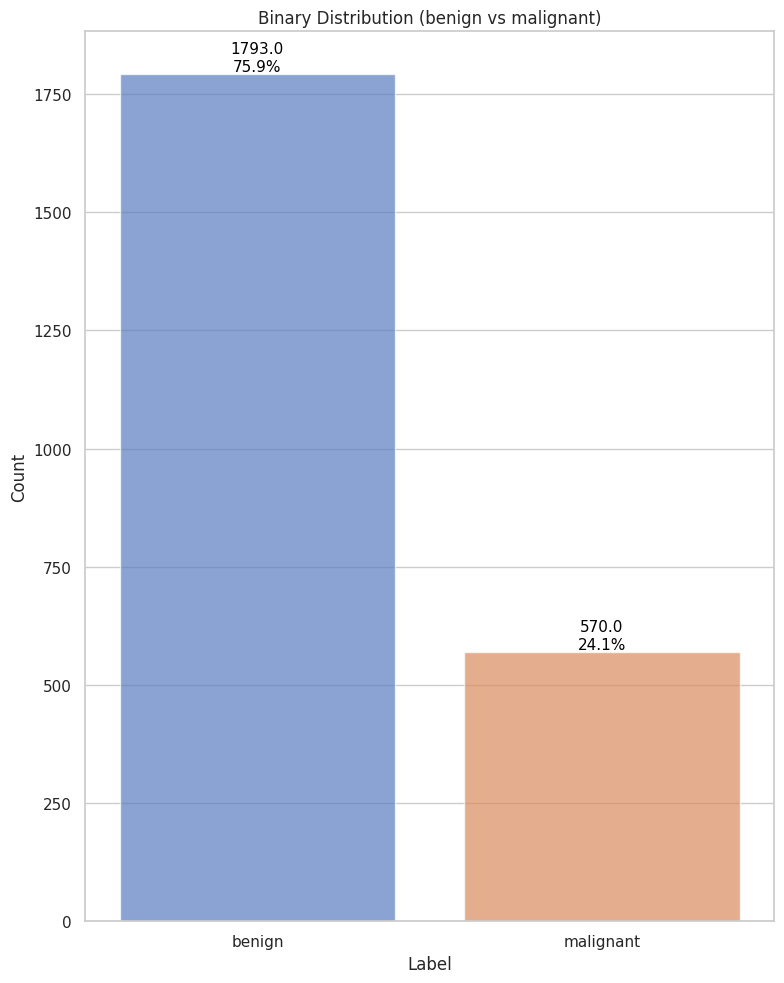

In [ ]:
# map to binary labels, then print and plot with counts and percentages
y_bin = np.where(y_full >= 4, 1, 0)
uniq, cnts = np.unique(y_bin, return_counts=True)
total_bin = y_bin.shape[0]
print('Binary distribution:')
print(f'  benign (0): {cnts[uniq.tolist().index(0)]} ({cnts[uniq.tolist().index(0)]/total_bin*100:.2f}%)')
print(f'  malignant (1): {cnts[uniq.tolist().index(1)]} ({cnts[uniq.tolist().index(1)]/total_bin*100:.2f}%)')

plt.figure(figsize=(8,10))
ax2 = sns.countplot(x=y_bin, palette='muted', alpha=0.7)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}\n{height/total_bin*100:.1f}%',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=11, color='black')
ax2.set_title('Binary Distribution (benign vs malignant)')
ax2.set_xlabel('Label')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['benign','malignant'])
ax2.set_ylabel('Count')
plt.tight_layout()
plt.show()

The dataset exhibits a high degree of imbalance, with class 3 being significantly overrepresented and class 5 notably underrepresented. We tackle this issue through a progressive three-part strategy:

 1. Class Weights
 2. Upsampling with (Offline) Data Augmentation
 3. Synthetic Image Generation with GANs

Each of these methods was chosen based on empirical evidence and best practices in the literature for CT imaging and deep learning applications. Their combined effect aims to reduce class bias, improve recall for minority classes, and build a more robust predictive model.

## Upsampling with (Offline) Data Augmentation

Different types of augmentations derived from literature. Aprameters based on best practices. Testing with different parameters too would have resulted in exponential gorwth of models to train and this was against available resources, therefore decided to base augmentation parameter choice on best practices derived from literature.

Decided to compare two approaches: the traditional one based on photometric and geomtric augmentations, and an advanced one based on mixing augmentations on top of traditional.

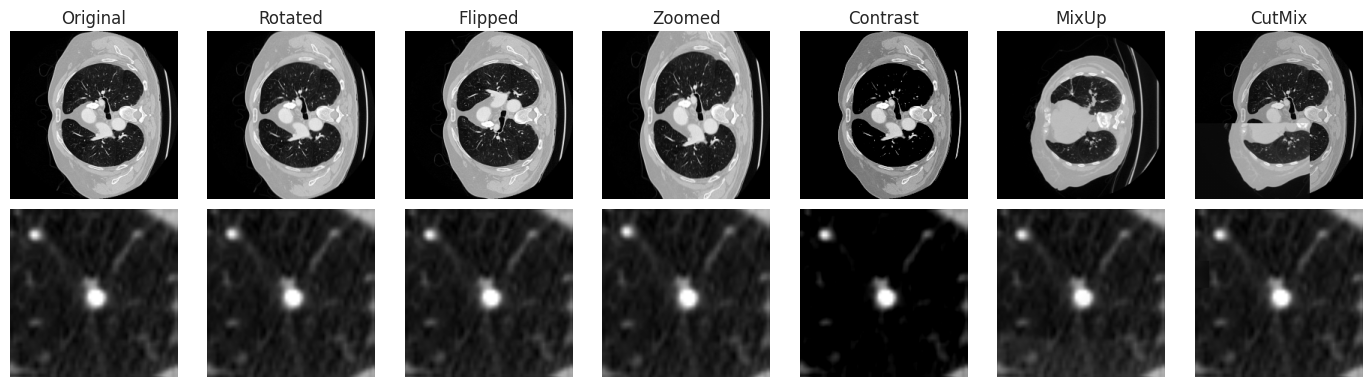

In [ ]:
# Pick one random example and one different partner from each dataset
idx_f1, idx_f2 = random.sample(range(len(X_full)), 2)
img_full_1 = X_full[idx_f1]
img_full_2 = X_full[idx_f2]

idx_n1, idx_n2 = random.sample(range(len(X_nod)), 2)
img_nod_1 = X_nod[idx_n1]
img_nod_2 = X_nod[idx_n2]

# Keras layers
rot_layer      = tf.keras.layers.RandomRotation(15/360, fill_mode='nearest')
flip_layer     = tf.keras.layers.RandomFlip(mode='horizontal')
zoom_layer     = tf.keras.layers.RandomZoom((-0.2,0.0), (-0.2,0.0), fill_mode='nearest')
contrast_layer = tf.keras.layers.RandomContrast(0.1)

# MixUp & CutMix
def mixup(img1, img2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    return lam * img1 + (1 - lam) * img2

def cutmix(img1, img2, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    h, w = img1.shape[:2]
    cut_rat = np.sqrt(1 - lam)
    ch, cw = int(h*cut_rat), int(w*cut_rat)
    cx, cy = np.random.randint(w), np.random.randint(h)
    x1, y1 = np.clip(cx-cw//2,0,w), np.clip(cy-ch//2,0,h)
    x2, y2 = np.clip(cx+cw//2,0,w), np.clip(cy+ch//2,0,h)
    out = img1.copy()
    out[y1:y2, x1:x2] = img2[y1:y2, x1:x2]
    return out

# Helper to apply TF layer to a single image
def apply_tf_layer(layer, img):
    t = tf.convert_to_tensor(img[None,...], dtype=tf.float32)
    return layer(t, training=True)[0].numpy()

# Visualize augmentations
titles = ["Original","Rotated","Flipped","Zoomed","Contrast","MixUp","CutMix"]
fig, axs = plt.subplots(2, len(titles), figsize=(14,4))

for col, title in enumerate(titles):
    axs[0, col].set_title(title)

for row in range(2):
    if row == 0:
        img, partner = img_full_1, img_full_2
    else:
        img, partner = img_nod_1, img_nod_2

    variants = [
        img,
        apply_tf_layer(rot_layer, img),
        apply_tf_layer(flip_layer, img),
        apply_tf_layer(zoom_layer, img),
        apply_tf_layer(contrast_layer, img),
        mixup(img, partner, alpha=0.2),
        cutmix(img, partner, alpha=1.0)
    ]

    for col, var in enumerate(variants):
        axs[row, col].imshow(var.squeeze(), cmap='gray')
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In order to address class imbalance one has to first split the dataset such that there is no information leak and the testing results biased. Decided to split ina  stratified way in order to preserve the original imbalanced distribution (e.g., 10.33%, 19.34%, 46.21%, 17.69%, 6.43%)—this yields realistic evaluation metrics.

In [ ]:
# Import libraries and set seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

seed = 42

# Load dataset and rename columns for full slices and nodule slices
df = pd.read_excel("dataset_lung.xlsx")
full_df = df.rename(columns={"Full_slice": "filename", "TumorClass": "label"})
nod_df  = df.rename(columns={"Nodule": "filename", "TumorClass": "label"})

# Helper function for 80/10/10 stratified split (returns train, val, test indices)
def stratified_80_10_10_indices(df, seed):
    idx = np.arange(len(df))

    # First, hold out 10% for the test set
    train_val_idx, test_idx = train_test_split(
        idx,
        test_size=0.10,
        stratify=df["label"],
        random_state=seed
    )

    # Then, split remaining 90% into train and validation (1/9 ≈ 11.11% for val)
    train_idx, val_idx = train_test_split(
        train_val_idx,
        test_size=1/9,
        stratify=df["label"].iloc[train_val_idx],
        random_state=seed
    )

    return train_idx, val_idx, test_idx

# Apply stratified split for both full-slice and nodule datasets
train_idx_f5, val_idx_f5, test_idx_f5 = stratified_80_10_10_indices(full_df, seed)
full_train5 = full_df.iloc[train_idx_f5].reset_index(drop=True)
full_val5   = full_df.iloc[val_idx_f5].reset_index(drop=True)
full_test5  = full_df.iloc[test_idx_f5].reset_index(drop=True)

train_idx_n5, val_idx_n5, test_idx_n5 = stratified_80_10_10_indices(nod_df, seed)
nod_train5 = nod_df.iloc[train_idx_n5].reset_index(drop=True)
nod_val5   = nod_df.iloc[val_idx_n5].reset_index(drop=True)
nod_test5  = nod_df.iloc[test_idx_n5].reset_index(drop=True)

Class distribution for Full Train (5-class):
  1: 195
  2: 365
  3: 873
  4: 334
  5: 122
------------------------------
Class distribution for Full Val (5-class):
  1: 25
  2: 46
  3: 109
  4: 42
  5: 15
------------------------------
Class distribution for Full Test (5-class):
  1: 24
  2: 46
  3: 110
  4: 42
  5: 15
------------------------------


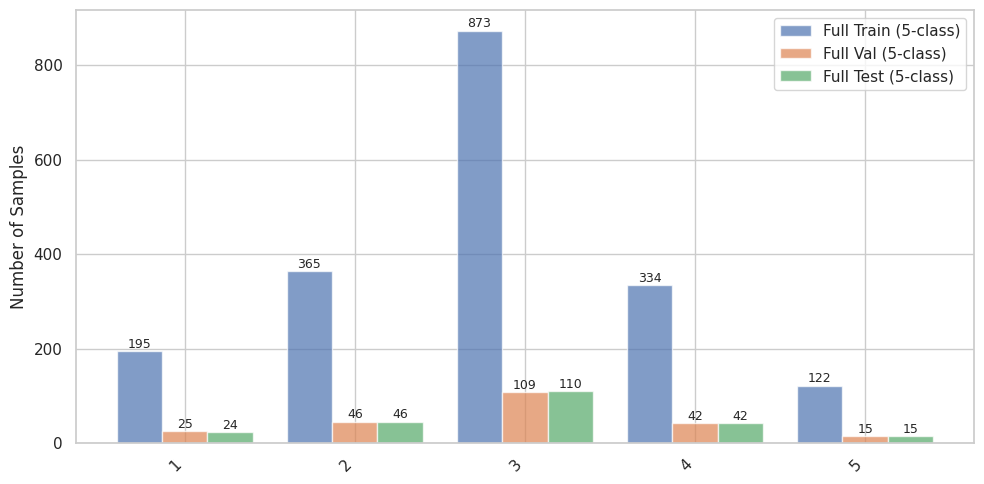

Class distribution for Nod Train (5-class):
  1: 195
  2: 365
  3: 873
  4: 334
  5: 122
------------------------------
Class distribution for Nod Val (5-class):
  1: 25
  2: 46
  3: 109
  4: 42
  5: 15
------------------------------
Class distribution for Nod Test (5-class):
  1: 24
  2: 46
  3: 110
  4: 42
  5: 15
------------------------------


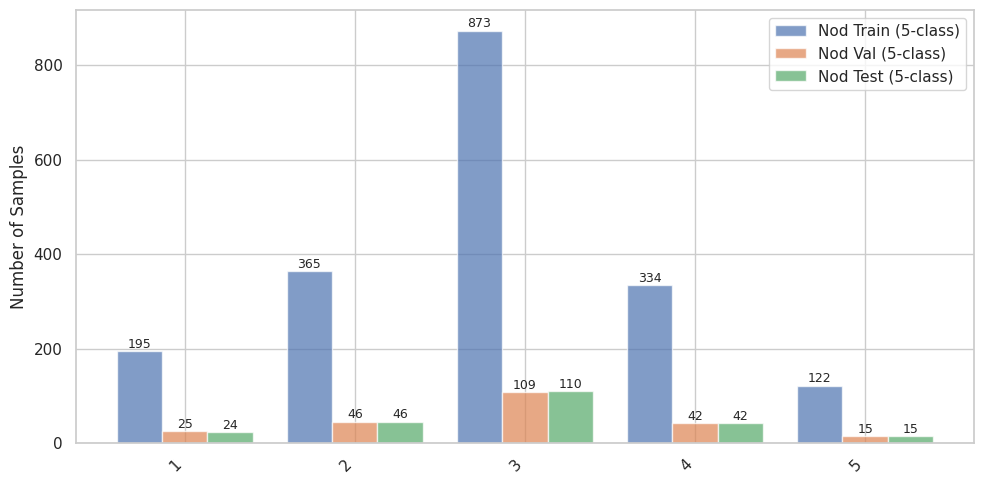

In [ ]:
# Helper function to plot class distributions
def plot_class_distribution(y_vectors, class_names, dataset_names=None):
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(y_vectors))]

    y_vectors = [np.ravel(y).astype(int) for y in y_vectors]

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 5))

    max_label = max(y.max() for y in y_vectors)
    dists = [np.bincount(y, minlength=max_label+1)[1:] for y in y_vectors]

    for name, dist in zip(dataset_names, dists):
        print(f"Class distribution for {name}:")
        for i, cnt in enumerate(dist):
            print(f"  {class_names[i]}: {cnt}")
        print("-" * 30)

    x = np.arange(len(class_names))
    width = 0.8 / len(y_vectors)

    for i, dist in enumerate(dists):
        bars = plt.bar(x + i*width, dist, width, label=dataset_names[i], alpha=0.7)
        for bar in bars:
            plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
                     int(bar.get_height()), ha='center', va='bottom', fontsize=9)

    plt.xticks(x + width*(len(y_vectors)-1)/2, class_names, rotation=45, ha='right')
    plt.ylabel("Number of Samples")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Class names for 5-class tumor classification
class5 = ['1', '2', '3', '4', '5']

# Plot class distributions for full-slice and nodule datasets (5-class splits)
plot_class_distribution(
    [full_train5['label'], full_val5['label'], full_test5['label']],
    class_names=class5,
    dataset_names=['Full Train (5-class)', 'Full Val (5-class)', 'Full Test (5-class)']
)

plot_class_distribution(
    [nod_train5['label'], nod_val5['label'], nod_test5['label']],
    class_names=class5,
    dataset_names=['Nod Train (5-class)', 'Nod Val (5-class)', 'Nod Test (5-class)']
)

For the binary task (classes 1–3 vs. 4–5), simply grouping the balanced 5-class set will not yield a balanced binary set—the malignant group (classes 4+5) will total 570 samples vs. 1 793 benign (classes 1–3). Therefore, after combining, we upsampled again malignant to 1 793 (or to another chosen target) rather than relying solely on the 5-class augmentation.

In [ ]:
# Create binary labels: 0 (benign, classes 1–3), 1 (malignant, classes 4–5)
label_map = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1}

for df in [full_train5, full_val5, full_test5,
           nod_train5,  nod_val5,  nod_test5]:
    df['label'] = df['label'].astype(int)
    df['label2'] = df['label'].map(label_map)

# Extract 5-class (original) arrays
X_full_train5 = X_full[train_idx_f5]
y_full_train5 = full_train5['label'].values
X_full_val5   = X_full[val_idx_f5]
y_full_val5   = full_val5['label'].values

X_nod_train5  = X_nod[train_idx_n5]
y_nod_train5  = nod_train5['label'].values
X_nod_val5    = X_nod[val_idx_n5]
y_nod_val5    = nod_val5['label'].values

# Extract 2-class (binary) arrays
X_full_train2 = X_full_train5
y_full_train2 = full_train5['label2'].values
X_full_val2   = X_full_val5
y_full_val2   = full_val5['label2'].values

X_nod_train2  = X_nod_train5
y_nod_train2  = nod_train5['label2'].values
X_nod_val2    = X_nod_val5
y_nod_val2    = nod_val5['label2'].values

# Extract 2-class (binary) test sets
X_full_test2 = X_full[test_idx_f5]
y_full_test2 = full_test5['label2'].values

X_nod_test2 = X_nod[test_idx_n5]
y_nod_test2 = nod_test5['label2'].values

Class distribution for Full Train (2-class):
  benign: 456
------------------------------
Class distribution for Full Val (2-class):
  benign: 57
------------------------------
Class distribution for Full Test (2-class):
  benign: 57
------------------------------


Class distribution for Nod Train (2-class):
  benign: 456
------------------------------
Class distribution for Nod Val (2-class):
  benign: 57
------------------------------
Class distribution for Nod Test (2-class):
  benign: 57
------------------------------


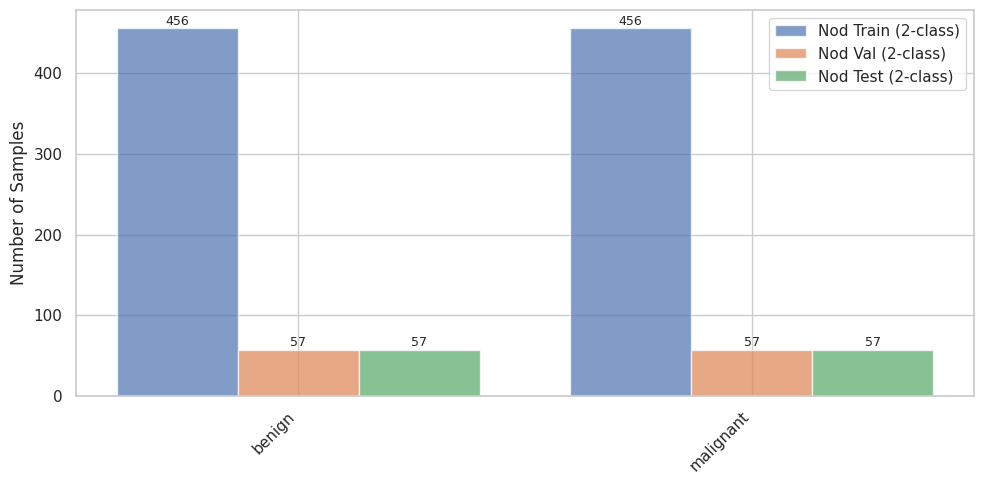

In [ ]:
# Class names for binary classification
class2 = ['benign', 'malignant']

# Plot class distributions for full-slice and nodule datasets (binary splits)
plot_class_distribution(
    [full_train5['label2'], full_val5['label2'], full_test5['label2']],
    class_names=class2,
    dataset_names=['Full Train (2-class)', 'Full Val (2-class)', 'Full Test (2-class)']
)

plot_class_distribution(
    [nod_train5['label2'], nod_val5['label2'], nod_test5['label2']],
    class_names=class2,
    dataset_names=['Nod Train (2-class)', 'Nod Val (2-class)', 'Nod Test (2-class)']
)

Decided to perform upsampling up to the majority class. JUSTIFY

Decided to employ two different approaches i.e. traditional and advanced. parameter values (FOR NOW) derived from literature

In [ ]:
# Traditional augmentation: simple sequence of transforms
def trad_augment(img, class_imgs=None):
    img = apply_tf_layer(rot_layer, img)
    img = apply_tf_layer(flip_layer, img)
    img = apply_tf_layer(zoom_layer, img)
    img = apply_tf_layer(contrast_layer, img)
    return img

# Traditional + mixing augmentation: sometimes mixup or cutmix with a same‐class partner
def mix_augment(img, class_imgs):
    if len(class_imgs) < 2 or random.random() < 0.5:
        return trad_augment(img)
    partner = random.choice(class_imgs)
    return mixup(img, partner) if random.random() < 0.5 else cutmix(img, partner)

# Oversample each class up to target_per_class, using augment_fn(img, class_imgs)
def oversample_dataset(X, y, target_per_class, augment_fn):
    X_aug = list(X)
    y_aug = list(y)
    classes, counts = np.unique(y, return_counts=True)
    to_generate = sum(max(0, target_per_class - cnt) for cnt in counts)
    pbar = tqdm(total=to_generate, desc="Generating aug samples")

    # group originals by class
    class_to_imgs = {c: [X[i] for i in np.where(y == c)[0]] for c in classes}

    for c, cnt in zip(classes, counts):
        need = target_per_class - cnt
        if need <= 0:
            continue
        imgs = class_to_imgs[c]
        for _ in range(need):
            src = random.choice(imgs)
            X_aug.append(augment_fn(src, imgs))
            y_aug.append(c)
            pbar.update(1)

    pbar.close()
    return np.stack(X_aug), np.array(y_aug)

Now creating the 4 balanced training sets for each approach

In [ ]:
# Determine majority‐class counts in each training split
maj_full5 = np.max(np.bincount(y_full_train5))
maj_full2 = np.max(np.bincount(y_full_train2))
maj_nod5  = np.max(np.bincount(y_nod_train5))
maj_nod2  = np.max(np.bincount(y_nod_train2))

# Oversample each dataset
# Full-slice 5-class traditional oversampling
X_full5_trad, y_full5_trad = oversample_dataset(
    X_full_train5, y_full_train5, maj_full5, trad_augment
)
# Full-slice 5-class mix oversampling
X_full5_mix,  y_full5_mix  = oversample_dataset(
    X_full_train5, y_full_train5, maj_full5, mix_augment
)

# Full-slice 2-class traditional oversampling
X_full2_trad, y_full2_trad = oversample_dataset(
    X_full_train2, y_full_train2, maj_full2, trad_augment
)
# Full-slice 2-class mix oversampling
X_full2_mix,  y_full2_mix  = oversample_dataset(
    X_full_train2, y_full_train2, maj_full2, mix_augment
)

# Nodule-slice 5-class traditional oversampling
X_nod5_trad, y_nod5_trad = oversample_dataset(
    X_nod_train5, y_nod_train5, maj_nod5, trad_augment
)
# Nodule-slice 5-class mix oversampling
X_nod5_mix,  y_nod5_mix  = oversample_dataset(
    X_nod_train5, y_nod_train5, maj_nod5, mix_augment
)

# Nodule-slice 2-class traditional oversampling
X_nod2_trad, y_nod2_trad = oversample_dataset(
    X_nod_train2, y_nod_train2, maj_nod2, trad_augment
)
# Nodule-slice 2-class mix oversampling
X_nod2_mix,  y_nod2_mix  = oversample_dataset(
    X_nod_train2, y_nod_train2, maj_nod2, mix_augment
)

# Verify balanced counts
print("Full 5-class traditional:",   np.bincount(y_full5_trad))
print("Full 5-class mix:",           np.bincount(y_full5_mix))
print("Full 2-class traditional:",   np.bincount(y_full2_trad))
print("Full 2-class mix:",           np.bincount(y_full2_mix))
print("Nod 5-class traditional:",    np.bincount(y_nod5_trad))
print("Nod 5-class mix:",            np.bincount(y_nod5_mix))
print("Nod 2-class traditional:",    np.bincount(y_nod2_trad))
print("Nod 2-class mix:",            np.bincount(y_nod2_mix))


Generating aug samples: 100%|██████████| 2476/2476 [01:27<00:00, 28.15it/s]

Generating aug samples: 100%|██████████| 2476/2476 [00:45<00:00, 53.84it/s]

Generating aug samples: 100%|██████████| 977/977 [00:35<00:00, 27.49it/s]

Generating aug samples: 100%|██████████| 977/977 [00:18<00:00, 53.32it/s]

Generating aug samples: 100%|██████████| 2476/2476 [01:36<00:00, 25.68it/s]

Generating aug samples: 100%|██████████| 2476/2476 [00:47<00:00, 52.10it/s]

Generating aug samples: 100%|██████████| 977/977 [00:39<00:00, 24.51it/s]

Generating aug samples: 100%|██████████| 977/977 [00:20<00:00, 47.24it/s]


Full 5-class traditional: [  0 873 873 873 873 873]
Full 5-class mix: [  0 873 873 873 873 873]
Full 2-class traditional: [1433 1433]
Full 2-class mix: [1433 1433]
Nod 5-class traditional: [  0 873 873 873 873 873]
Nod 5-class mix: [  0 873 873 873 873 873]
Nod 2-class traditional: [1433 1433]
Nod 2-class mix: [1433 1433]


In [ ]:
# Saving balanced splits to .npz (traditional and mix versions)
# Full-slice 5-class traditional
np.savez(
    "full5_trad.npz",
    X_train=X_full5_trad, y_train=y_full5_trad,
    X_val=  X_full_val5,   y_val=  y_full_val5,
    X_test= X_full[test_idx_f5], y_test=full_test5["label"].values
)

# Full-slice 5-class mix
np.savez(
    "full5_mix.npz",
    X_train=X_full5_mix, y_train=y_full5_mix,
    X_val=  X_full_val5,   y_val=  y_full_val5,
    X_test= X_full[test_idx_f5], y_test=full_test5["label"].values
)

# Full-slice 2-class traditional
np.savez(
    "full2_trad.npz",
    X_train=X_full2_trad, y_train=y_full2_trad,
    X_val=  X_full_val2,   y_val=  y_full_val2,
    X_test= X_full[test_idx_f5], y_test=full_test5["label2"].values
)

# Full-slice 2-class mix
np.savez(
    "full2_mix.npz",
    X_train=X_full2_mix, y_train=y_full2_mix,
    X_val=  X_full_val2,   y_val=  y_full_val2,
    X_test= X_full[test_idx_f5], y_test=full_test5["label2"].values
)

# Nodule-slice 5-class traditional
np.savez(
    "nod5_trad.npz",
    X_train=X_nod5_trad, y_train=y_nod5_trad,
    X_val=  X_nod_val5,   y_val=  y_nod_val5,
    X_test= X_nod[test_idx_n5], y_test=nod_test5["label"].values
)

# Nodule-slice 5-class mix
np.savez(
    "nod5_mix.npz",
    X_train=X_nod5_mix, y_train=y_nod5_mix,
    X_val=  X_nod_val5,   y_val=  y_nod_val5,
    X_test= X_nod[test_idx_n5], y_test=nod_test5["label"].values
)

# Nodule-slice 2-class traditional
np.savez(
    "nod2_trad.npz",
    X_train=X_nod2_trad, y_train=y_nod2_trad,
    X_val=  X_nod_val2,   y_val=  y_nod_val2,
    X_test= X_nod[test_idx_n5], y_test=nod_test5["label2"].values
)

# Nodule-slice 2-class mix
np.savez(
    "nod2_mix.npz",
    X_train=X_nod2_mix, y_train=y_nod2_mix,
    X_val=  X_nod_val2,   y_val=  y_nod_val2,
    X_test= X_nod[test_idx_n5], y_test=nod_test5["label2"].values
)

## Testing Augmentations on Each Model Task

### 5 Class Full Slice

In [ ]:
d_trad = np.load("balanced_datasets/full5_trad.npz", mmap_mode='r')
X_trn_t, y_trn_t = d_trad["X_train"], d_trad["y_train"]
X_val_t, y_val_t = d_trad["X_val"],   d_trad["y_val"]
X_tst_t, y_tst_t = d_trad["X_test"],  d_trad["y_test"]

d_mix  = np.load("balanced_datasets/full5_mix.npz", mmap_mode='r')
X_trn_m, y_trn_m = d_mix["X_train"], d_mix["y_train"]
X_val_m, y_val_m = d_mix["X_val"],   d_mix["y_val"]
X_tst_m, y_tst_m = d_mix["X_test"],  d_mix["y_test"]

In [ ]:
N_CLASSES    = 5

def make_ds(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y), seed=seed)

    def _prep(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.expand_dims(image, axis=-1)             # (H, W, 1)
        image = tf.image.grayscale_to_rgb(image)           # (H, W, 3)
        label = tf.one_hot(label, depth=N_CLASSES)         # 5-way one-hot
        return image, label

    return (
        ds
        .map(_prep, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

In [ ]:
def build_model(input_shape):
    base = keras.applications.DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # Freeze first fraction of layers
    n_freeze = int(len(base.layers) * FREEZE_RATIO)
    for layer in base.layers[:n_freeze]:
        layer.trainable = False
    for layer in base.layers[n_freeze:]:
        layer.trainable = True

    inp = keras.Input(shape=input_shape)
    x   = base(inp, training=False)
    x   = keras.layers.GlobalAveragePooling2D()(x)
    out = keras.layers.Dense(N_CLASSES, activation="softmax")(x)
    return keras.Model(inp, out)

In [ ]:
def train_and_eval(X_train, y_train, X_val, y_val, X_test, y_test):
    ds_tr  = make_ds(X_train, y_train, shuffle=True)
    ds_val = make_ds(X_val,   y_val)
    ds_te  = make_ds(X_test,  y_test)

    shape = (X_train.shape[1], X_train.shape[2], 3)
    model = build_model(shape)

    # Phase 1: train head only
    model.compile(
        optimizer=keras.optimizers.Adam(LR_HEAD),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            F1Score(average="macro", name="f1_score")
        ]
    )
    h1 = model.fit(ds_tr, validation_data=ds_val, epochs=HEAD_EPOCHS, verbose=1)

    # Phase 2: unfreeze & fine-tune
    for layer in model.layers:
        layer.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(LR_FINE),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            F1Score(average="macro", name="f1_score")
        ]
    )
    h2 = model.fit(ds_tr, validation_data=ds_val, epochs=FINE_TUNE_EPOCHS, verbose=1)

    # Final evaluation
    results = model.evaluate(ds_te, return_dict=True)

    # Merge histories
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history.get(key, [])
    return history, results

In [ ]:
hist_t, res_t = train_and_eval(
    X_trn_t, y_trn_t,
    X_val_t, y_val_t,
    X_tst_t, y_tst_t
)
print(f"Traditional — loss {res_t['loss']:.4f}, acc {res_t['accuracy']:.4f}, f1 {res_t['f1_score']:.4f}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.3554 - f1_score: 0.2984 - loss: 1.2824 - val_accuracy: 0.3376 - val_f1_score: 0.1839 - val_loss: 1.3393
Epoch 2/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 73s 183ms/step - accuracy: 0.5495 - f1_score: 0.4771 - loss: 0.7446 - val_accuracy: 0.4557 - val_f1_score: 0.2403 - val_loss: 1.2135
Epoch 3/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.5399 - f1_score: 0.4760 - loss: 0.6914 - val_accuracy: 0.3291 - val_f1_score: 0.1876 - val_loss: 1.2801
Epoch 1/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6303 - f1_score: 0.5663 - loss: 0.5070 - val_accuracy: 0.4135 - val_f1_score: 0.2229 - val_loss: 1.2373
Epoch 2/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 79s 183ms/step - accuracy: 0.6802 - f1_score: 0.6062 - loss: 0.4273 - val_accuracy: 0.4135 - val_f1_score: 0.2137 - val_loss: 1.2622
Epoch 3/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.7019 - f1_score: 0.6287 -

In [ ]:
hist_m, res_m = train_and_eval(
    X_trn_m, y_trn_m,
    X_val_m, y_val_m,
    X_tst_m, y_tst_m
)
print(f"Mix         — loss {res_m['loss']:.4f}, acc {res_m['accuracy']:.4f}, f1 {res_m['f1_score']:.4f}")

Epoch 1/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.3276 - f1_score: 0.2749 - loss: 1.2327 - val_accuracy: 0.3797 - val_f1_score: 0.2244 - val_loss: 1.3225
Epoch 2/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 26s 186ms/step - accuracy: 0.6391 - f1_score: 0.5579 - loss: 0.6419 - val_accuracy: 0.3586 - val_f1_score: 0.2171 - val_loss: 1.2745
Epoch 3/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.6454 - f1_score: 0.5619 - loss: 0.5778 - val_accuracy: 0.3502 - val_f1_score: 0.2503 - val_loss: 1.3195
Epoch 1/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.7311 - f1_score: 0.6569 - loss: 0.3725 - val_accuracy: 0.3966 - val_f1_score: 0.2472 - val_loss: 1.2795
Epoch 2/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 79s 182ms/step - accuracy: 0.7626 - f1_score: 0.6779 - loss: 0.3009 - val_accuracy: 0.4219 - val_f1_score: 0.2332 - val_loss: 1.2988
Epoch 3/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.7717 - f1_score: 0.6880 - loss: 0.2461 - val_accuracy: 0.4219 - val_f1_score

In [ ]:
epochs = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, hist_t["accuracy"],    "-o", label="Trad Train Acc")
plt.plot(epochs, hist_t["val_accuracy"],"-o", label="Trad Val Acc")
plt.plot(epochs, hist_m["accuracy"],    "-s", label="Mix Train Acc")
plt.plot(epochs, hist_m["val_accuracy"],"-s", label="Mix Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Trad vs Mix Accuracy (5-class)"); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, hist_t["f1_score"],     "-o", label="Trad Train F1")
plt.plot(epochs, hist_t["val_f1_score"], "-o", label="Trad Val F1")
plt.plot(epochs, hist_m["f1_score"],     "-s", label="Mix Train F1")
plt.plot(epochs, hist_m["val_f1_score"], "-s", label="Mix Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1-Score")
plt.title("Trad vs Mix F1-Score (5-class)"); plt.legend(); plt.show()

In [ ]:
import numpy as np
import pickle

# Build the data structure
full5 = {
    "epochs": np.array(range(1, TOTAL_EPOCHS + 1)),
    "trad": {
        "train_accuracy": np.array(hist_t["accuracy"]),
        "val_accuracy": np.array(hist_t["val_accuracy"]),
        "train_f1": np.array(hist_t["f1_score"]),
        "val_f1": np.array(hist_t["val_f1_score"]),
    },
    "mix": {
        "train_accuracy": np.array(hist_m["accuracy"]),
        "val_accuracy": np.array(hist_m["val_accuracy"]),
        "train_f1": np.array(hist_m["f1_score"]),
        "val_f1": np.array(hist_m["val_f1_score"]),
    }
}

with open("full5_data.pkl", "wb") as f:
    pickle.dump(full5, f)

### Binary Full Slice

In [ ]:
# Memory-map your datasets instead of loading fully
d_trad = np.load("balanced_datasets/full2_trad.npz", mmap_mode='r')
X_trn_t, y_trn_t = d_trad["X_train"], d_trad["y_train"]
X_val_t, y_val_t = d_trad["X_val"],   d_trad["y_val"]
X_tst_t, y_tst_t = d_trad["X_test"],  d_trad["y_test"]

d_mix = np.load("balanced_datasets/full2_mix.npz", mmap_mode='r')
X_trn_m, y_trn_m = d_mix["X_train"], d_mix["y_train"]
X_val_m, y_val_m = d_mix["X_val"],   d_mix["y_val"]
X_tst_m, y_tst_m = d_mix["X_test"],  d_mix["y_test"]

In [ ]:
def make_ds(X, y, shuffle=False):
    """
    Streams grayscale images from the memmap X,
    converts to RGB on-the-fly, one-hot encodes labels, batches & prefetches.
    """
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y), seed=seed)

    def _prep(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.expand_dims(image, axis=-1)
        image = tf.image.grayscale_to_rgb(image)
        label = tf.one_hot(label, depth=2)      # <-- one-hot here
        return image, label

    return ds.map(_prep, num_parallel_calls=tf.data.AUTOTUNE) \
             .batch(BATCH_SIZE) \
             .prefetch(tf.data.AUTOTUNE)

In [ ]:
def build_model(input_shape):
    base = keras.applications.DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    # freeze first FREEZE_RATIO fraction of layers
    n_freeze = int(len(base.layers) * FREEZE_RATIO)
    for layer in base.layers[:n_freeze]:
        layer.trainable = False
    for layer in base.layers[n_freeze:]:
        layer.trainable = True

    inp = keras.Input(shape=input_shape)
    x = base(inp, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    # <-- two outputs for binary classification
    out = keras.layers.Dense(2, activation="softmax")(x)
    return keras.Model(inp, out)

In [ ]:
def train_and_eval(X_train, y_train, X_val, y_val, X_test, y_test):
    ds_tr  = make_ds(X_train, y_train, shuffle=True)
    ds_val = make_ds(X_val,   y_val)
    ds_te  = make_ds(X_test,  y_test)

    shape = (X_train.shape[1], X_train.shape[2], 3)
    model = build_model(shape)

    # Phase 1: head-only
    model.compile(
        optimizer=keras.optimizers.Adam(LR_HEAD),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            F1Score(average="macro", name="f1_score")
        ]
    )
    h1 = model.fit(ds_tr, validation_data=ds_val, epochs=HEAD_EPOCHS, verbose=2)

    # Phase 2: unfreeze all
    for layer in model.layers:
        layer.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(LR_FINE),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            F1Score(average="macro", name="f1_score")
        ]
    )
    h2 = model.fit(ds_tr, validation_data=ds_val, epochs=FINE_TUNE_EPOCHS, verbose=2)


    results = model.evaluate(ds_te, return_dict=True)

    history = {}
    for k in h1.history:
        history[k] = h1.history[k] + h2.history.get(k, [])
    return history, results

In [ ]:
hist_t, res_t = train_and_eval(
    X_trn_t, y_trn_t,
    X_val_t, y_val_t,
    X_tst_t, y_tst_t
)
print(f"Traditional — loss {res_t['loss']:.4f}, "
      f"acc {res_t['accuracy']:.4f}, f1 {res_t['f1_score']:.4f}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3
79/79 - 243s - 3s/step - accuracy: 0.8042 - f1_score: 0.8032 - loss: 0.4325 - val_accuracy: 0.7046 - val_f1_score: 0.5857 - val_loss: 0.5754
Epoch 2/3
79/79 - 28s - 358ms/step - accuracy: 0.9226 - f1_score: 0.9225 - loss: 0.1931 - val_accuracy: 0.7595 - val_f1_score: 0.4919 - val_loss: 0.5840
Epoch 3/3
79/79 - 21s - 261ms/step - accuracy: 0.9689 - f1_score: 0.9689 - loss: 0.1036 - val_accuracy: 0.7764 - val_f1_score: 0.6396 - val_loss: 0.6118
Epoch 1/7
79/79 - 219s - 3s/step - accuracy: 0.9924 - f1_score: 0.9924 - loss: 0.0331 - val_accuracy: 0.7848 - val_f1_score: 0.5871 - val_loss: 0.7408
Epoch 2/7
79/79 - 51s - 640ms/step - accuracy: 0.9976 - f1_score: 0.9976 - loss: 0.0165 - val_accuracy: 0.7848 - val_f1_score: 0.5961 - val_loss: 0.7646
Epoch 3/7
79/79 - 14s - 178ms/step - accuracy: 0.9976 - f1_score: 0.9976 - loss: 0.0147 - val_accuracy: 0.7848 - val_f1_score: 0.5961 - val_loss: 0.7983
Epoch 4/7
79/79 - 21s - 260ms/step 

In [ ]:
hist_m, res_m = train_and_eval(
    X_trn_m, y_trn_m,
    X_val_m, y_val_m,
    X_tst_m, y_tst_m
)
print(f"Mix         — loss {res_m['loss']:.4f}, "
      f"acc {res_m['accuracy']:.4f}, f1 {res_m['f1_score']:.4f}")

Epoch 1/3
79/79 - 225s - 3s/step - accuracy: 0.7795 - f1_score: 0.7785 - loss: 0.4534 - val_accuracy: 0.7511 - val_f1_score: 0.4600 - val_loss: 0.5955
Epoch 2/3
79/79 - 46s - 581ms/step - accuracy: 0.9633 - f1_score: 0.9633 - loss: 0.1245 - val_accuracy: 0.7553 - val_f1_score: 0.5550 - val_loss: 0.6331
Epoch 3/3
79/79 - 20s - 259ms/step - accuracy: 0.9876 - f1_score: 0.9876 - loss: 0.0539 - val_accuracy: 0.7722 - val_f1_score: 0.5769 - val_loss: 0.7751
Epoch 1/7
79/79 - 228s - 3s/step - accuracy: 0.9960 - f1_score: 0.9960 - loss: 0.0217 - val_accuracy: 0.7848 - val_f1_score: 0.5776 - val_loss: 0.9847
Epoch 2/7
79/79 - 42s - 530ms/step - accuracy: 0.9980 - f1_score: 0.9980 - loss: 0.0117 - val_accuracy: 0.7848 - val_f1_score: 0.5961 - val_loss: 0.9340
Epoch 3/7
79/79 - 14s - 179ms/step - accuracy: 0.9976 - f1_score: 0.9976 - loss: 0.0124 - val_accuracy: 0.7806 - val_f1_score: 0.5926 - val_loss: 0.9602
Epoch 4/7
79/79 - 20s - 259ms/step - accuracy: 0.9988 - f1_score: 0.9988 - loss: 0.007

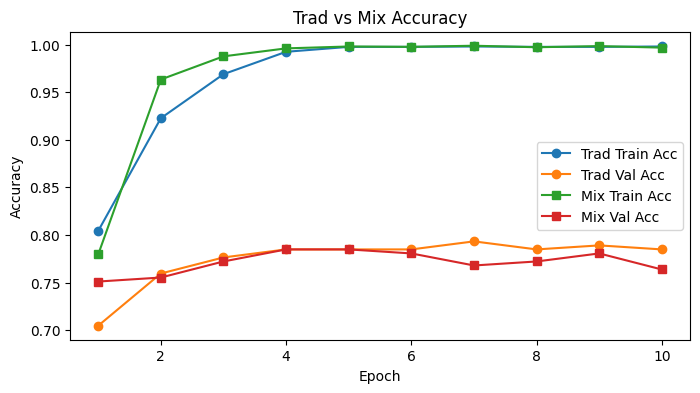

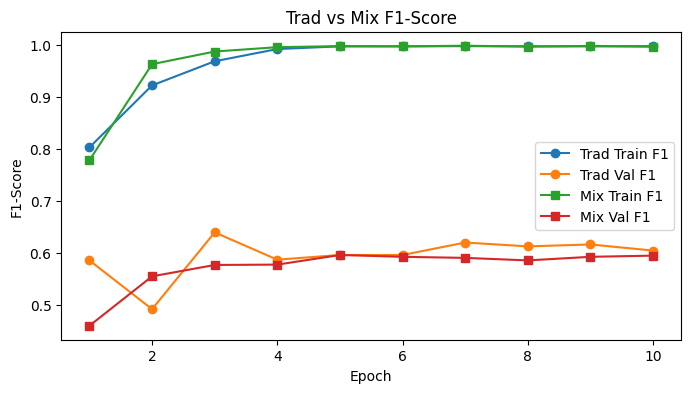

In [ ]:
epochs = range(1, TOTAL_EPOCHS+1)

plt.figure(figsize=(8,4))
plt.plot(epochs, hist_t["accuracy"],    "-o", label="Trad Train Acc")
plt.plot(epochs, hist_t["val_accuracy"],"-o", label="Trad Val Acc")
plt.plot(epochs, hist_m["accuracy"],    "-s", label="Mix Train Acc")
plt.plot(epochs, hist_m["val_accuracy"],"-s", label="Mix Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Trad vs Mix Accuracy"); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, hist_t["f1_score"],     "-o", label="Trad Train F1")
plt.plot(epochs, hist_t["val_f1_score"], "-o", label="Trad Val F1")
plt.plot(epochs, hist_m["f1_score"],     "-s", label="Mix Train F1")
plt.plot(epochs, hist_m["val_f1_score"], "-s", label="Mix Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1-Score")
plt.title("Trad vs Mix F1-Score"); plt.legend(); plt.show()

In [ ]:
# Build the data structure
full2 = {
    "epochs": np.array(range(1, TOTAL_EPOCHS + 1)),
    "trad": {
        "train_accuracy": np.array(hist_t["accuracy"]),
        "val_accuracy": np.array(hist_t["val_accuracy"]),
        "train_f1": np.array(hist_t["f1_score"]),
        "val_f1": np.array(hist_t["val_f1_score"]),
    },
    "mix": {
        "train_accuracy": np.array(hist_m["accuracy"]),
        "val_accuracy": np.array(hist_m["val_accuracy"]),
        "train_f1": np.array(hist_m["f1_score"]),
        "val_f1": np.array(hist_m["val_f1_score"]),
    }
}

with open("full2_data.pkl", "wb") as f:
    pickle.dump(full2, f)

### 5 Class Nodule Slice

In [ ]:
d_trad = np.load("balanced_datasets/nod5_trad.npz", mmap_mode='r')
X_trn_t, y_trn_t = d_trad["X_train"], d_trad["y_train"]
X_val_t, y_val_t = d_trad["X_val"],   d_trad["y_val"]
X_tst_t, y_tst_t = d_trad["X_test"],  d_trad["y_test"]

d_mix  = np.load("balanced_datasets/nod5_mix.npz", mmap_mode='r')
X_trn_m, y_trn_m = d_mix["X_train"], d_mix["y_train"]
X_val_m, y_val_m = d_mix["X_val"],   d_mix["y_val"]
X_tst_m, y_tst_m = d_mix["X_test"],  d_mix["y_test"]

In [ ]:
N_CLASSES    = 5

def make_ds(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y), seed=seed)

    def _prep(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.expand_dims(image, axis=-1)             # (H, W, 1)
        image = tf.image.grayscale_to_rgb(image)           # (H, W, 3)
        label = tf.one_hot(label, depth=N_CLASSES)         # 5-way one-hot
        return image, label

    return (
        ds
        .map(_prep, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

In [ ]:
def build_model(input_shape):
    base = keras.applications.ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # Freeze first fraction of layers
    n_freeze = int(len(base.layers) * FREEZE_RATIO)
    for layer in base.layers[:n_freeze]:
        layer.trainable = False
    for layer in base.layers[n_freeze:]:
        layer.trainable = True

    inp = keras.Input(shape=input_shape)
    x   = base(inp, training=False)
    x   = keras.layers.GlobalAveragePooling2D()(x)
    out = keras.layers.Dense(N_CLASSES, activation="softmax")(x)
    return keras.Model(inp, out)

In [ ]:
def train_and_eval(X_train, y_train, X_val, y_val, X_test, y_test):
    ds_tr  = make_ds(X_train, y_train, shuffle=True)
    ds_val = make_ds(X_val,   y_val)
    ds_te  = make_ds(X_test,  y_test)

    shape = (X_train.shape[1], X_train.shape[2], 3)
    model = build_model(shape)

    # Phase 1: train head only
    model.compile(
        optimizer=keras.optimizers.Adam(LR_HEAD),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            F1Score(average="macro", name="f1_score")
        ]
    )
    h1 = model.fit(ds_tr, validation_data=ds_val, epochs=HEAD_EPOCHS, verbose=1)

    # Phase 2: unfreeze & fine-tune
    for layer in model.layers:
        layer.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(LR_FINE),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            F1Score(average="macro", name="f1_score")
        ]
    )
    h2 = model.fit(ds_tr, validation_data=ds_val, epochs=FINE_TUNE_EPOCHS, verbose=1)

    # Final evaluation
    results = model.evaluate(ds_te, return_dict=True)

    # Merge histories
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history.get(key, [])
    return history, results

In [ ]:
hist_t, res_t = train_and_eval(
    X_trn_t, y_trn_t,
    X_val_t, y_val_t,
    X_tst_t, y_tst_t
)
print(f"Traditional — loss {res_t['loss']:.4f}, acc {res_t['accuracy']:.4f}, f1 {res_t['f1_score']:.4f}")

Epoch 1/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 144s 805ms/step - accuracy: 0.2866 - f1_score: 0.2453 - loss: 1.1649 - val_accuracy: 0.4557 - val_f1_score: 0.1883 - val_loss: 1.1608
Epoch 2/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 68s 568ms/step - accuracy: 0.4349 - f1_score: 0.3839 - loss: 0.8632 - val_accuracy: 0.3671 - val_f1_score: 0.2630 - val_loss: 1.1003
Epoch 3/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 73s 607ms/step - accuracy: 0.4745 - f1_score: 0.4278 - loss: 0.7609 - val_accuracy: 0.5612 - val_f1_score: 0.3659 - val_loss: 1.0143
Epoch 1/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 131s 785ms/step - accuracy: 0.5644 - f1_score: 0.5150 - loss: 0.6331 - val_accuracy: 0.5527 - val_f1_score: 0.3799 - val_loss: 0.9886
Epoch 2/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 107s 608ms/step - accuracy: 0.5824 - f1_score: 0.5270 - loss: 0.5883 - val_accuracy: 0.5274 - val_f1_score: 0.3788 - val_loss: 0.9944
Epoch 3/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 609ms/step - accuracy: 0.5947 - f1_score: 0.5434 - loss: 0.5586 - val_accuracy: 0.5401 - val_f

In [ ]:
hist_m, res_m = train_and_eval(
    X_trn_m, y_trn_m,
    X_val_m, y_val_m,
    X_tst_m, y_tst_m
)
print(f"Mix         — loss {res_m['loss']:.4f}, acc {res_m['accuracy']:.4f}, f1 {res_m['f1_score']:.4f}")

Epoch 1/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 136s 822ms/step - accuracy: 0.3164 - f1_score: 0.2732 - loss: 1.1307 - val_accuracy: 0.4895 - val_f1_score: 0.2468 - val_loss: 1.1484
Epoch 2/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 103s 605ms/step - accuracy: 0.3881 - f1_score: 0.3479 - loss: 0.9396 - val_accuracy: 0.5148 - val_f1_score: 0.3780 - val_loss: 1.0381
Epoch 3/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 72s 602ms/step - accuracy: 0.4645 - f1_score: 0.4150 - loss: 0.8122 - val_accuracy: 0.5781 - val_f1_score: 0.3855 - val_loss: 0.9528
Epoch 1/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 136s 824ms/step - accuracy: 0.5682 - f1_score: 0.5177 - loss: 0.6090 - val_accuracy: 0.5781 - val_f1_score: 0.4081 - val_loss: 0.9334
Epoch 2/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 605ms/step - accuracy: 0.5950 - f1_score: 0.5409 - loss: 0.5533 - val_accuracy: 0.5105 - val_f1_score: 0.3993 - val_loss: 0.9769
Epoch 3/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 609ms/step - accuracy: 0.6200 - f1_score: 0.5663 - loss: 0.4994 - val_accuracy: 0.5316 - val_

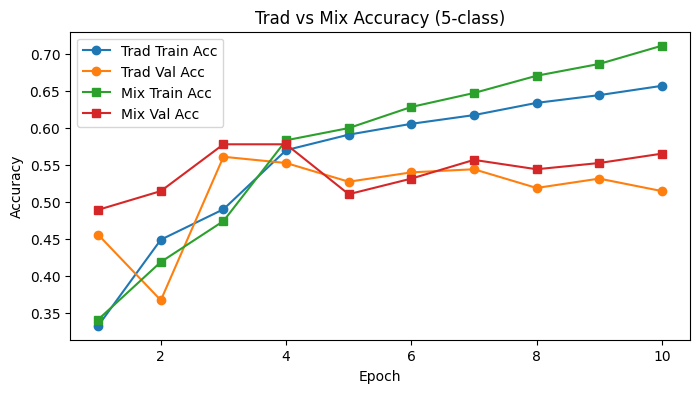

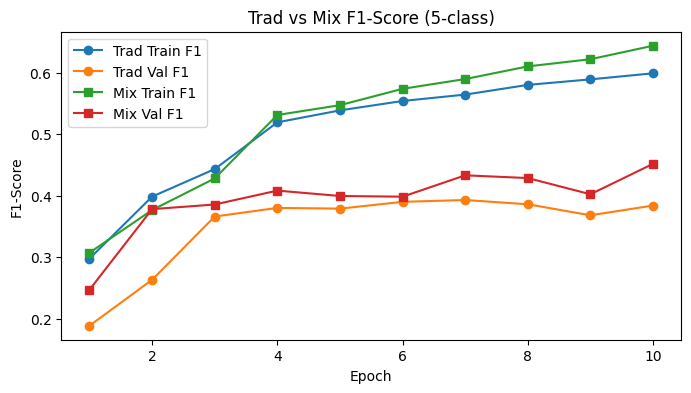

In [ ]:
# Plot training curves
epochs = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, hist_t["accuracy"],    "-o", label="Trad Train Acc")
plt.plot(epochs, hist_t["val_accuracy"],"-o", label="Trad Val Acc")
plt.plot(epochs, hist_m["accuracy"],    "-s", label="Mix Train Acc")
plt.plot(epochs, hist_m["val_accuracy"],"-s", label="Mix Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Trad vs Mix Accuracy (5-class)"); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, hist_t["f1_score"],     "-o", label="Trad Train F1")
plt.plot(epochs, hist_t["val_f1_score"], "-o", label="Trad Val F1")
plt.plot(epochs, hist_m["f1_score"],     "-s", label="Mix Train F1")
plt.plot(epochs, hist_m["val_f1_score"], "-s", label="Mix Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1-Score")
plt.title("Trad vs Mix F1-Score (5-class)"); plt.legend(); plt.show()

In [ ]:
import numpy as np
import pickle

# Build the data structure
nod5 = {
    "epochs": np.array(range(1, TOTAL_EPOCHS + 1)),
    "trad": {
        "train_accuracy": np.array(hist_t["accuracy"]),
        "val_accuracy": np.array(hist_t["val_accuracy"]),
        "train_f1": np.array(hist_t["f1_score"]),
        "val_f1": np.array(hist_t["val_f1_score"]),
    },
    "mix": {
        "train_accuracy": np.array(hist_m["accuracy"]),
        "val_accuracy": np.array(hist_m["val_accuracy"]),
        "train_f1": np.array(hist_m["f1_score"]),
        "val_f1": np.array(hist_m["val_f1_score"]),
    }
}

with open("nod5_data.pkl", "wb") as f:
    pickle.dump(nod5, f)

### Binary Full Slice

In [ ]:
# Memory-map datasets instead of loading fully
d_trad = np.load("balanced_datasets/nod2_trad.npz", mmap_mode='r')
X_trn_t, y_trn_t = d_trad["X_train"], d_trad["y_train"]
X_val_t, y_val_t = d_trad["X_val"],   d_trad["y_val"]
X_tst_t, y_tst_t = d_trad["X_test"],  d_trad["y_test"]

d_mix = np.load("balanced_datasets/nod2_mix.npz", mmap_mode='r')
X_trn_m, y_trn_m = d_mix["X_train"], d_mix["y_train"]
X_val_m, y_val_m = d_mix["X_val"],   d_mix["y_val"]
X_tst_m, y_tst_m = d_mix["X_test"],  d_mix["y_test"]

In [ ]:
def make_ds(X, y, shuffle=False):
    """
    Streams grayscale images from the memmap X,
    converts to RGB on-the-fly, one-hot encodes labels, batches & prefetches.
    """
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y), seed=seed)

    def _prep(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.expand_dims(image, axis=-1)
        image = tf.image.grayscale_to_rgb(image)
        label = tf.one_hot(label, depth=2)      # <-- one-hot here
        return image, label

    return ds.map(_prep, num_parallel_calls=tf.data.AUTOTUNE) \
             .batch(BATCH_SIZE) \
             .prefetch(tf.data.AUTOTUNE)

In [ ]:
def build_model(input_shape):
    base = keras.applications.ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    # freeze first FREEZE_RATIO fraction of layers
    n_freeze = int(len(base.layers) * FREEZE_RATIO)
    for layer in base.layers[:n_freeze]:
        layer.trainable = False
    for layer in base.layers[n_freeze:]:
        layer.trainable = True

    inp = keras.Input(shape=input_shape)
    x = base(inp, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    # <-- two outputs for binary classification
    out = keras.layers.Dense(2, activation="softmax")(x)
    return keras.Model(inp, out)

In [ ]:
def train_and_eval(X_train, y_train, X_val, y_val, X_test, y_test):
    ds_tr  = make_ds(X_train, y_train, shuffle=True)
    ds_val = make_ds(X_val,   y_val)
    ds_te  = make_ds(X_test,  y_test)

    shape = (X_train.shape[1], X_train.shape[2], 3)
    model = build_model(shape)

    # Phase 1: head-only
    model.compile(
        optimizer=keras.optimizers.Adam(LR_HEAD),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            F1Score(average="macro", name="f1_score")
        ]
    )
    h1 = model.fit(ds_tr, validation_data=ds_val, epochs=HEAD_EPOCHS, verbose=2)

    # Phase 2: unfreeze all
    for layer in model.layers:
        layer.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(LR_FINE),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            F1Score(average="macro", name="f1_score")
        ]
    )
    h2 = model.fit(ds_tr, validation_data=ds_val, epochs=FINE_TUNE_EPOCHS, verbose=2)


    results = model.evaluate(ds_te, return_dict=True)

    history = {}
    for k in h1.history:
        history[k] = h1.history[k] + h2.history.get(k, [])
    return history, results

In [ ]:
hist_t, res_t = train_and_eval(
    X_trn_t, y_trn_t,
    X_val_t, y_val_t,
    X_tst_t, y_tst_t
)
print(f"Traditional — loss {res_t['loss']:.4f}, "
      f"acc {res_t['accuracy']:.4f}, f1 {res_t['f1_score']:.4f}")

Epoch 1/3
79/79 - 108s - 1s/step - accuracy: 0.7963 - f1_score: 0.7950 - loss: 0.4293 - val_accuracy: 0.8397 - val_f1_score: 0.7556 - val_loss: 0.4726
Epoch 2/3
79/79 - 108s - 1s/step - accuracy: 0.8740 - f1_score: 0.8734 - loss: 0.3069 - val_accuracy: 0.8776 - val_f1_score: 0.8091 - val_loss: 0.3641
Epoch 3/3
79/79 - 82s - 1s/step - accuracy: 0.8995 - f1_score: 0.8993 - loss: 0.2408 - val_accuracy: 0.8945 - val_f1_score: 0.8404 - val_loss: 0.3282
Epoch 1/7
79/79 - 107s - 1s/step - accuracy: 0.9334 - f1_score: 0.9334 - loss: 0.1764 - val_accuracy: 0.8819 - val_f1_score: 0.8226 - val_loss: 0.3230
Epoch 2/7
79/79 - 48s - 607ms/step - accuracy: 0.9442 - f1_score: 0.9441 - loss: 0.1586 - val_accuracy: 0.8861 - val_f1_score: 0.8301 - val_loss: 0.3295
Epoch 3/7
79/79 - 47s - 590ms/step - accuracy: 0.9458 - f1_score: 0.9458 - loss: 0.1459 - val_accuracy: 0.8776 - val_f1_score: 0.8149 - val_loss: 0.3299
Epoch 4/7
79/79 - 83s - 1s/step - accuracy: 0.9557 - f1_score: 0.9557 - loss: 0.1315 - val_

In [ ]:
hist_m, res_m = train_and_eval(
    X_trn_m, y_trn_m,
    X_val_m, y_val_m,
    X_tst_m, y_tst_m
)
print(f"Mix         — loss {res_m['loss']:.4f}, "
      f"acc {res_m['accuracy']:.4f}, f1 {res_m['f1_score']:.4f}")

Epoch 1/3
79/79 - 108s - 1s/step - accuracy: 0.7887 - f1_score: 0.7887 - loss: 0.4616 - val_accuracy: 0.8819 - val_f1_score: 0.8226 - val_loss: 0.3463
Epoch 2/3
79/79 - 49s - 622ms/step - accuracy: 0.9007 - f1_score: 0.9007 - loss: 0.2604 - val_accuracy: 0.8819 - val_f1_score: 0.8226 - val_loss: 0.3222
Epoch 3/3
79/79 - 82s - 1s/step - accuracy: 0.9502 - f1_score: 0.9502 - loss: 0.1504 - val_accuracy: 0.8734 - val_f1_score: 0.8099 - val_loss: 0.3851
Epoch 1/7
79/79 - 106s - 1s/step - accuracy: 0.9868 - f1_score: 0.9868 - loss: 0.0541 - val_accuracy: 0.8565 - val_f1_score: 0.7876 - val_loss: 0.4113
Epoch 2/7
79/79 - 48s - 610ms/step - accuracy: 0.9936 - f1_score: 0.9936 - loss: 0.0330 - val_accuracy: 0.8565 - val_f1_score: 0.7845 - val_loss: 0.4401
Epoch 3/7
79/79 - 81s - 1s/step - accuracy: 0.9936 - f1_score: 0.9936 - loss: 0.0212 - val_accuracy: 0.8523 - val_f1_score: 0.7991 - val_loss: 0.4621
Epoch 4/7
79/79 - 47s - 597ms/step - accuracy: 0.9984 - f1_score: 0.9984 - loss: 0.0131 - va

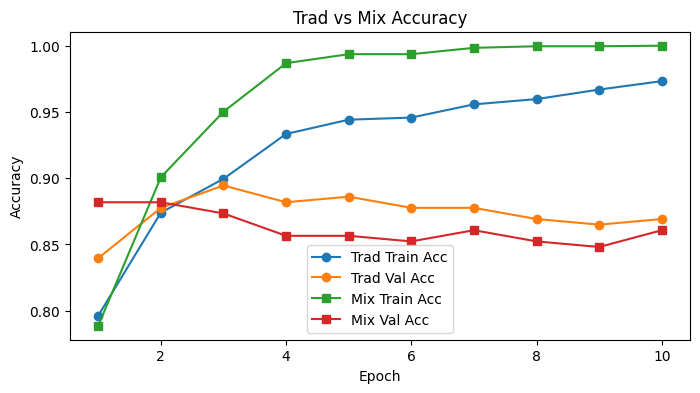

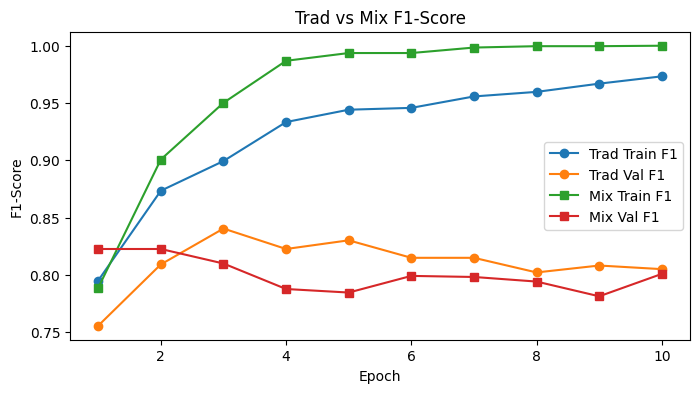

In [ ]:
epochs = range(1, TOTAL_EPOCHS+1)

plt.figure(figsize=(8,4))
plt.plot(epochs, hist_t["accuracy"],    "-o", label="Trad Train Acc")
plt.plot(epochs, hist_t["val_accuracy"],"-o", label="Trad Val Acc")
plt.plot(epochs, hist_m["accuracy"],    "-s", label="Mix Train Acc")
plt.plot(epochs, hist_m["val_accuracy"],"-s", label="Mix Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Trad vs Mix Accuracy"); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, hist_t["f1_score"],     "-o", label="Trad Train F1")
plt.plot(epochs, hist_t["val_f1_score"], "-o", label="Trad Val F1")
plt.plot(epochs, hist_m["f1_score"],     "-s", label="Mix Train F1")
plt.plot(epochs, hist_m["val_f1_score"], "-s", label="Mix Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1-Score")
plt.title("Trad vs Mix F1-Score"); plt.legend(); plt.show()

In [ ]:
# Build the data structure
nod2 = {
    "epochs": np.array(range(1, TOTAL_EPOCHS + 1)),
    "trad": {
        "train_accuracy": np.array(hist_t["accuracy"]),
        "val_accuracy": np.array(hist_t["val_accuracy"]),
        "train_f1": np.array(hist_t["f1_score"]),
        "val_f1": np.array(hist_t["val_f1_score"]),
    },
    "mix": {
        "train_accuracy": np.array(hist_m["accuracy"]),
        "val_accuracy": np.array(hist_m["val_accuracy"]),
        "train_f1": np.array(hist_m["f1_score"]),
        "val_f1": np.array(hist_m["val_f1_score"]),
    }
}

with open("nod2_data.pkl", "wb") as f:
    pickle.dump(nod2, f)

### Comparison

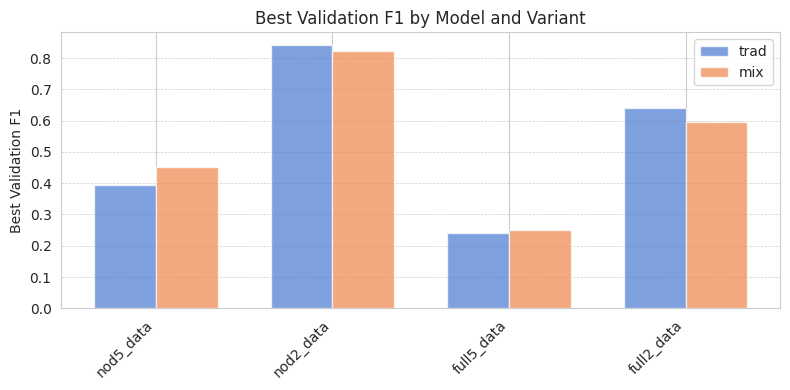

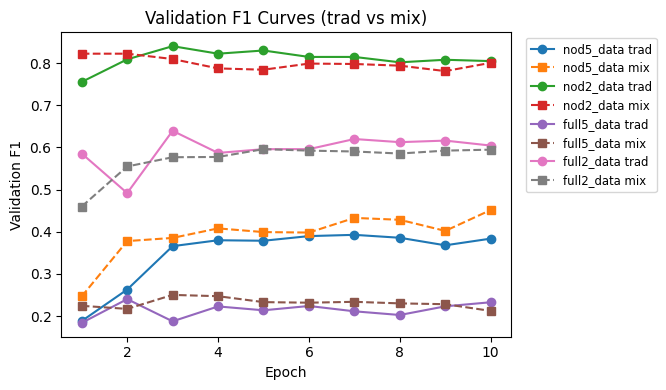

In [ ]:
# load histories
HIST_DIR = "model_training_histories"
files = glob.glob(os.path.join(HIST_DIR, "*.pkl"))
all_histories = {}
for fp in files:
    name = os.path.splitext(os.path.basename(fp))[0]
    with open(fp, "rb") as f:
        all_histories[name] = pickle.load(f)

# collect best val-F1
records = []
for model, hist in all_histories.items():
    for variant in ("trad", "mix"):
        vals = hist[variant]["val_f1"]
        best_i = int(vals.argmax())
        records.append({
            "model":      model,
            "variant":    variant,
            "best_epoch": best_i + 1,
            "best_val_f1": vals[best_i]
        })
df = pd.DataFrame(records)

# grouped bar chart
models = df["model"].unique()
x = np.arange(len(models))
width = 0.35
trad_vals = [df.loc[(df.model==m)&(df.variant=="trad"), "best_val_f1"].item() for m in models]
mix_vals  = [df.loc[(df.model==m)&(df.variant=="mix"),  "best_val_f1"].item() for m in models]
palette = sns.color_palette("muted")

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - width/2, trad_vals, width, color=palette[0], alpha=0.7, label="trad")
    ax.bar(x + width/2, mix_vals,  width, color=palette[1], alpha=0.7, label="mix")
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.set_ylabel("Best Validation F1")
    ax.set_title("Best Validation F1 by Model and Variant")
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5)   # horizontal grid lines
    ax.legend()
    plt.tight_layout()
    plt.show()

# overlay curves with legend outside
epochs = next(iter(all_histories.values()))["epochs"]
fig, ax = plt.subplots(figsize=(8,4))
for model, hist in all_histories.items():
    ax.plot(epochs, hist["trad"]["val_f1"], marker="o", linestyle="-", label=f"{model} trad")
    ax.plot(epochs, hist["mix"]["val_f1"],  marker="s", linestyle="--", label=f"{model} mix")
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation F1")
ax.set_title("Validation F1 Curves (trad vs mix)")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small", ncol=1)
plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

  ## Conditional DC-GAN for synthetic CT slices
  
  - Works with binary labels 0 / 1     (N_CLASSES == 2)
  - Expects images shaped (H, W) or (H, W, 1)    – grayscale
  - Adds SYNTHETIC_PER_CLS images per class to X_train / y_train


In [ ]:
# Hyper-parameters
LATENT_DIM        = 128          # length of the noise vector
EMBED_DIM         = 50           # label-embedding size
BATCH_GAN         = 64
EPOCHS_GAN        = 6000
SYNTHETIC_PER_CLS = 2000         # #fakes per class (≈ class-balancing)
IMG_SHAPE         = (X_train.shape[1], X_train.shape[2], 1)
N_CLASSES         = 2
lr_D              = 0.0002
lr_G              = 0.0004
beta_1 = 0.5
GAN_SEED          = 42           # keep GAN repeatable

tf.random.set_seed(GAN_SEED);  np.random.seed(GAN_SEED)

In [ ]:
# Prep real images → scale to [-1,+1] and add channel dim
def _scale_to_minus1_plus1(imgs):
    if imgs.ndim == 3:                       # (N,H,W)
        imgs = imgs[..., None]               # → (N,H,W,1)
    imgs = imgs.astype("float32")
    imgs = imgs / (127.5 if imgs.max() > 1.5 else 0.5) - 1.0
    return imgs

X_train_gan = _scale_to_minus1_plus1(X_train)

###  Build generator & discriminator

In [ ]:
def make_generator(IMG_SHAPE=(224, 224, 1)): # Pass IMG_SHAPE as an argument
    z     = layers.Input(shape=(LATENT_DIM,))
    label = layers.Input(shape=(1,))

    # label embedding → mask
    e = layers.Embedding(N_CLASSES, EMBED_DIM)(label)
    # Reshape to match generator's output shape
    e = layers.Dense(np.prod(IMG_SHAPE), activation='linear')(e)
    e = layers.Reshape(IMG_SHAPE)(e)

    x = layers.Dense(8*8*256, use_bias=False)(z)
    x = layers.Reshape((8,8,256))(x)
    x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)

    # Adjusted strides and kernel sizes to reach the desired output shape (224, 224, 1)
    x = layers.Conv2DTranspose(128, 7, strides=7, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(1, 4, strides=2, padding="same", activation="tanh")(x)

    # fuse the label mask & clean-up with 1×1 conv
    merged = layers.Concatenate()([x, e])
    out    = layers.Conv2D(1, 1, activation="tanh")(merged)
    return Model([z, label], out, name="G")

# Create the generator instance, passing the image shape
G = make_generator(IMG_SHAPE=IMG_SHAPE)
G.summary()

Model: "G"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 16384)     │  2,097,152 │ input_layer_46[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_29          │ (None, 8, 8, 256) │          0 │ dense_35[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ reshape_29[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_42      │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_30 │ (None, 56, 56,    │  1,605,632 │ leaky_re_lu_42[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_43      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_31 │ (None, 112, 112,  │    131,072 │ leaky_re_lu_43[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_47      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 1, 50)     │        100 │ input_layer_47[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_44      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1, 50176)  │  2,558,976 │ embedding_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_32 │ (None, 224, 224,  │      1,025 │ leaky_re_lu_44[0… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_28          │ (None, 224, 224,  │          0 │ dense_34[0][0]    │
│ (Reshape)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 224, 224,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 2)                │            │ reshape_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,395,752 (24.40 MB)

 Trainable params: 6,394,856 (24.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
def make_discriminator():
    img = layers.Input(shape=IMG_SHAPE)  # Input for the image
    label = layers.Input(shape=(1,))  # Input for the label

    # Embed the label
    embedded_label = layers.Embedding(N_CLASSES, EMBED_DIM)(label)
    embedded_label = layers.Dense(np.prod(IMG_SHAPE), activation="relu")(embedded_label)
    embedded_label = layers.Reshape(IMG_SHAPE)(embedded_label)

    # Concatenate the embedded label with the image
    merged = layers.Concatenate()([img, embedded_label])

    # Process the merged input
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same')(merged)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Flatten and output a single value (real/fake)
    x = layers.Flatten()(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    return Model([img, label], out, name="D")  # Output a single value indicating real/fake

In [ ]:
# Create instances of the generator and discriminator
G = make_generator()
D = make_discriminator()

# Compile the discriminator
D.compile(loss='binary_crossentropy',
          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5),
          metrics=['accuracy'])
D.summary()

# Build the GAN
z = layers.Input(shape=(LATENT_DIM,))
label = layers.Input(shape=(1,))
img = G([z, label])  # Generate an image
validity = D([img, label])  # Pass the generated image to the discriminator
GAN = Model([z, label], validity, name="GAN")

# Create separate optimizers for generator and discriminator
# with distinct learning rates:
optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G, beta_1=0.5) # lr_G is your desired generator learning rate
optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D, beta_1=0.5) # lr_D is your desired discriminator learning rate

# Compile the GAN
GAN.compile(loss='binary_crossentropy', optimizer=optimizer_G)
GAN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 1, 50)     │        100 │ input_layer_51[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 1, 50176)  │  2,558,976 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_50      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_32          │ (None, 224, 224,  │          0 │ dense_38[0][0]    │
│ (Reshape)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 224, 224,  │          0 │ input_layer_50[0… │
│ (Concatenate)       │ 2)                │            │ reshape_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 112, 112,  │        608 │ concatenate_18[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_48      │ (None, 112, 112,  │          0 │ conv2d_24[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 112, 112,  │          0 │ leaky_re_lu_48[0… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 56, 56,    │     18,496 │ dropout_12[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_49      │ (None, 56, 56,    │          0 │ conv2d_25[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 56, 56,    │          0 │ leaky_re_lu_49[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 200704)    │          0 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1)         │    200,705 │ flatten_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,778,885 (10.60 MB)

 Trainable params: 2,778,885 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_52      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_53      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ G (Functional)      │ (None, 224, 224,  │  6,395,752 │ input_layer_52[0… │
│                     │ 1)                │            │ input_layer_53[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ D (Functional)      │ (None, 1)         │  2,778,885 │ G[0][0],          │
│                     │                   │            │ input_layer_53[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,174,637 (35.00 MB)

 Trainable params: 9,173,741 (35.00 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Training loop
real_y = np.ones((BATCH_GAN, 1))
fake_y = np.zeros((BATCH_GAN, 1))

# Initialize lists to store loss history
d_real_hist, d_fake_hist, g_hist = [], [], []

ds = (tf.data.Dataset
      .from_tensor_slices((X_train_gan, y_train))
      .shuffle(buffer_size=len(y_train), seed=GAN_SEED)
      .batch(BATCH_GAN, drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE))

for epoch in tqdm.trange(EPOCHS_GAN, desc="GAN training"):
    # pull one shuffled batch per epoch → faster but works fine here
    real_imgs, lbls = next(iter(ds))
    bs = real_imgs.shape[0]

    # train D on real
    d_r = D.train_on_batch([real_imgs, lbls], real_y[:bs])

    # train D on fake
    noise = np.random.normal(0, 1, (bs, LATENT_DIM))
    fake  = G.predict([noise, lbls], verbose=0)
    d_f   = D.train_on_batch([fake, lbls], fake_y[:bs])

    # train G to fool D
    noise = np.random.normal(0, 1, (bs, LATENT_DIM))
    g_loss = GAN.train_on_batch([noise, lbls], real_y[:bs])
    d_real_hist.append(d_r[0])
    d_fake_hist.append(d_f[0])
    g_hist.append(float(g_loss))

    if (epoch+1) % 500 == 0:
        print(f"[{epoch+1}/{EPOCHS_GAN}]  "
              f"D_real={d_r[0]:.3f}  D_fake={d_f[0]:.3f}  G={g_loss:.3f}")

GAN training:   8%|▊         | 500/6000 [02:49<32:05,  2.86it/s]

[500/6000]  D_real=1.542  D_fake=1.540  G=0.102


GAN training:  17%|█▋        | 1000/6000 [05:23<31:45,  2.62it/s]

[1000/6000]  D_real=2.506  D_fake=2.508  G=0.158


GAN training:  25%|██▌       | 1500/6000 [07:58<24:09,  3.11it/s]

[1500/6000]  D_real=3.427  D_fake=3.429  G=0.193


GAN training:  33%|███▎      | 2000/6000 [10:32<21:42,  3.07it/s]

[2000/6000]  D_real=3.792  D_fake=3.794  G=0.211


GAN training:  42%|████▏     | 2500/6000 [13:06<17:59,  3.24it/s]

[2500/6000]  D_real=4.227  D_fake=4.227  G=0.239


GAN training:  50%|█████     | 3000/6000 [15:42<15:06,  3.31it/s]

[3000/6000]  D_real=4.539  D_fake=4.541  G=0.281


GAN training:  58%|█████▊    | 3500/6000 [18:18<12:14,  3.40it/s]

[3500/6000]  D_real=4.803  D_fake=4.806  G=0.306


GAN training:  67%|██████▋   | 4000/6000 [20:53<09:52,  3.38it/s]

[4000/6000]  D_real=5.311  D_fake=5.314  G=0.350


GAN training:  75%|███████▌  | 4500/6000 [23:28<07:18,  3.42it/s]

[4500/6000]  D_real=5.869  D_fake=5.871  G=0.382


GAN training:  83%|████████▎ | 5000/6000 [26:02<04:48,  3.47it/s]

[5000/6000]  D_real=6.820  D_fake=6.820  G=0.453


GAN training:  92%|█████████▏| 5500/6000 [28:37<02:32,  3.28it/s]

[5500/6000]  D_real=8.050  D_fake=8.054  G=0.568


GAN training: 100%|██████████| 6000/6000 [31:12<00:00,  3.20it/s]

[6000/6000]  D_real=9.146  D_fake=9.149  G=0.785


### Generate synthetic dataset & add to training set


In [ ]:
# Generate synthetic dataset & add to training set
def generate_synthetic(per_cls=SYNTHETIC_PER_CLS):
    imgs, lbls = [], []
    batches    = (per_cls + BATCH_GAN - 1) // BATCH_GAN
    for cls in range(N_CLASSES):
        for _ in range(batches):
            z   = np.random.normal(0, 1, (BATCH_GAN, LATENT_DIM))
            lab = np.full((BATCH_GAN, 1), cls)
            g   = G.predict([z, lab], verbose=0)
            imgs.append(g);  lbls.append(lab)
    synth = np.concatenate(imgs)[:per_cls*N_CLASSES]
    labs  = np.concatenate(lbls).flatten()[:per_cls*N_CLASSES]
    synth = (synth + 1.) / 2.          # back to [0,1]
    return synth.squeeze(-1).astype('float32'), labs.astype('int32')

X_syn, y_syn = generate_synthetic()
print(f"Synthetic set → {X_syn.shape} (per class = {SYNTHETIC_PER_CLS})")

# add to main training arrays
X_train = np.concatenate([X_train, X_syn], axis=0)
y_train = np.concatenate([y_train, y_syn], axis=0)
print(f"Augmented X_train now has {X_train.shape[0]} samples.")

### Quick sanity check – display 4 random fake images / class


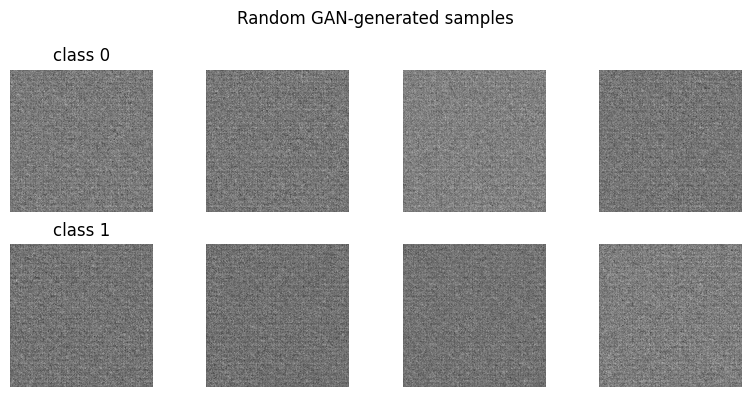

In [ ]:
# Quick sanity check – display 4 random fake images / class
fig, ax = plt.subplots(2, 4, figsize=(8,4))
for cls in range(N_CLASSES):
    idxs = np.random.choice(np.where(y_syn==cls)[0], 4, replace=False)
    for j, k in enumerate(idxs):
        ax[cls, j].imshow(X_syn[k], cmap='gray')
        ax[cls, j].axis('off')
        if j==0: ax[cls, j].set_title(f"class {cls}")
plt.suptitle("Random GAN-generated samples")
plt.tight_layout(); plt.show()

### Quick-look summary of how the GAN behaved


| Snapshot (every 500 iters) | **D real loss** | **D fake loss** | **G loss** | What that usually means                                                                                                     |
| -------------------------- | --------------- | --------------- | ---------- | --------------------------------------------------------------------------------------------------------------------------- |
| 500                        | 0.17            | 0.17            | 2.84       | D is doing a decent job (low BCE) and is clearly beating G.                                                                 |
| 3 000                      | 1.08            | 1.08            | 9.73       | D starts to mis-classify real & fake more often (loss ↑); G still loses the game (loss ↑ fast).                             |
| 6 000                      | 2.35            | 2.35            | 21.73      | D can hardly tell anything apart any more (loss near max of \~2.3 for BCE), yet G’s loss has exploded ⇒ overall divergence. |


#### Visual evidence
The 8-tile grid you printed (see above) shows feature-less grey speckle for both classes ‒ basically structured noise. No class-specific patterns, no obvious anatomical shapes.

#### Interpretation
- Training diverged after ~2 k iterations.

- Simultaneous growth of both D-losses and G-loss ⇒ the adversarial game moved into a region where gradients became uninformative.

- Large G-loss (≫ 1) = generator keeps producing images that D is very confident are fake.

- Mode collapse / noise collapse is visible: generator locked onto a high-frequency noise texture that maximises confusion early on, then never escaped.

- Discriminator accuracy actually dropped (loss ↑) even though the images stayed unrealistic. Classic symptom of vanishing gradients when D saturates and fails to provide a usable learning signal to G.



In [2]:
import datetime

# Create a timestamped output folder
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = f"gan_results_{stamp}"
os.makedirs(out_dir, exist_ok=True)

# Save raw history to CSV / JSON
history = {
    "d_real": d_real_hist,
    "d_fake": d_fake_hist,
    "g"     : g_hist
}
pd.DataFrame(history).to_csv(os.path.join(out_dir, "gan_history.csv"), index=False)


# Convert NumPy arrays to lists before saving to JSON
def convert_to_json_serializable(data):
    """Recursively converts NumPy arrays to lists for JSON serialization."""
    if isinstance(data, np.ndarray):
        return data.tolist()
    elif isinstance(data, list):
        return [convert_to_json_serializable(item) for item in data]
    elif isinstance(data, dict):
        return {key: convert_to_json_serializable(value)
                for key, value in data.items()}
    else:
        return data

history_json = convert_to_json_serializable(history)

with open(os.path.join(out_dir, "gan_history.json"), "w") as fp:
    # Use history_json instead of history for JSON serialization
    json.dump(history_json, fp, indent=2)

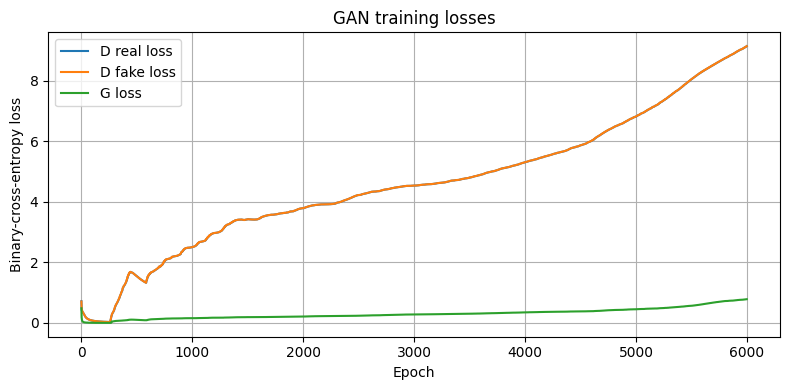

History & plot stored in → gan_results_20250503_143919
Generator / Discriminator checkpoints saved.


In [ ]:
# Plot losses
plt.figure(figsize=(8,4))
plt.plot(history["d_real"], label="D real loss")
plt.plot(history["d_fake"], label="D fake loss")
plt.plot(history["g"],      label="G loss")
plt.title("GAN training losses")
plt.xlabel("Epoch")
plt.ylabel("Binary-cross-entropy loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
fig_path = os.path.join(out_dir, "gan_losses.png")
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"History & plot stored in → {out_dir}")

# Save final model weights
G.save(os.path.join(out_dir, "generator_final.keras"))
D.save(os.path.join(out_dir, "discriminator_final.keras"))
print("Generator / Discriminator checkpoints saved.")